# Data Preprocessing

# Import All Necessary Library

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import multiprocessing
import tensorflow as tf
from tensorflow import keras
# from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline
from scikeras.wrappers import KerasRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from keras.callbacks import Callback
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, recall_score, precision_score,
    roc_auc_score, f1_score, confusion_matrix, fbeta_score
)

import os
import warnings

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING logs

# Load Dataset

In [2]:
# input_filepath = 'diabetes_scale.txt'
input_filepath = 'diabetes.txt'
data = []
with open(input_filepath, 'r') as file:
    for line in file:
        parts = line.strip().split()
        outcome_label = parts[0]
        features = {int(feature.split(":")[0]): float(feature.split(":")[1]) for feature in parts[1:]}
        features['outcome'] = outcome_label
        data.append(features)

# Convert to a pandas DataFrame
input_df = pd.DataFrame(data)
input_df['outcome'] = input_df['outcome'].map({'+1': 0, '-1': 1})
input_df

,1,2,3,4,5,6,7,8,outcome
0,6.0,148.0,72.0,35.0,0.0,33.599998,0.627,50.0,1
1,1.0,85.0,66.0,29.0,0.0,26.600000,0.351,31.0,0
2,8.0,183.0,64.0,0.0,0.0,23.299999,0.672,32.0,1
3,1.0,89.0,66.0,23.0,94.0,28.100000,0.167,21.0,0
4,0.0,137.0,40.0,35.0,168.0,43.099998,2.288,33.0,1
...,...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.0,180.0,32.900002,0.171,63.0,0
764,2.0,122.0,70.0,27.0,0.0,36.799999,0.340,27.0,0
765,5.0,121.0,72.0,23.0,112.0,26.200001,0.245,30.0,0
766,1.0,126.0,60.0,0.0,0.0,30.100000,0.349,47.0,1


# Name The Columns

In [3]:
input_df = input_df.rename(columns={
    1: 'Pregnancies',
    2: 'Glucose',
    3: 'BloodPressure',
    4: 'SkinThickness',
    5: 'Insulin',
    6: 'BMI',
    7: 'DiabetesPedigreeFunction',
    8: 'Age'
})
pd.options.display.float_format = '{:.2f}'.format
summary = input_df.drop(columns=['outcome']).describe()


# Summary Of The Data

In [4]:
summary

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00
mean,3.85,120.89,69.11,20.54,79.80,31.99,0.47,33.24
std,3.37,31.97,19.36,15.95,115.24,7.88,0.33,11.76
min,0.00,0.00,0.00,0.00,0.00,0.00,0.08,21.00
25%,1.00,99.00,62.00,0.00,0.00,27.30,0.24,24.00
50%,3.00,117.00,72.00,23.00,30.50,32.00,0.37,29.00
75%,6.00,140.25,80.00,32.00,127.25,36.60,0.63,41.00
max,17.00,199.00,122.00,99.00,846.00,67.10,2.42,81.00


# Show Histogram 

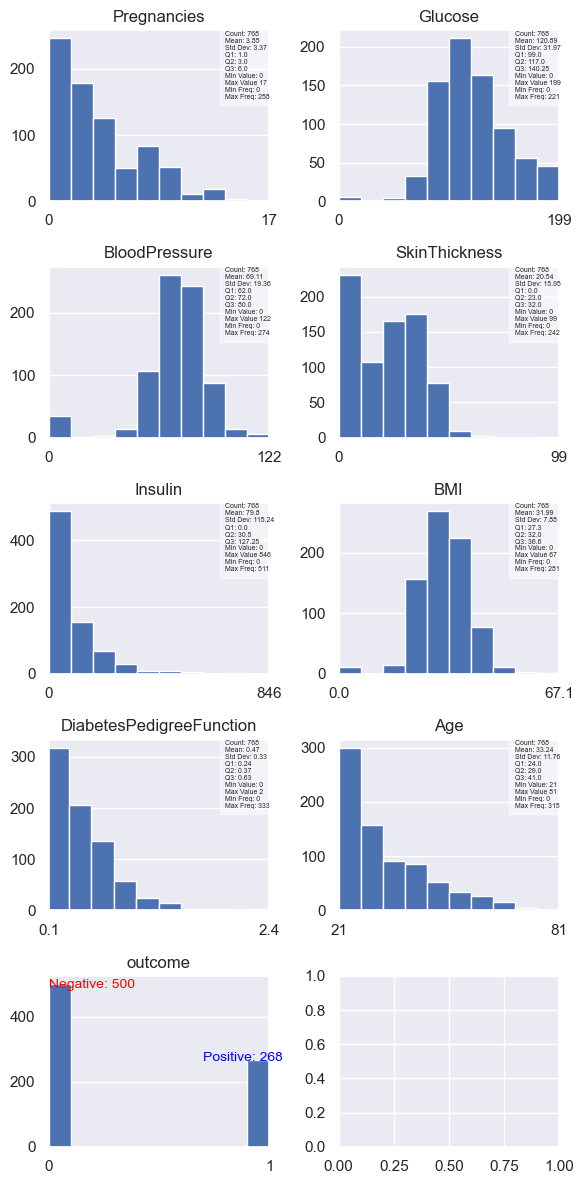

In [5]:
sns.set()

fig, axes = plt.subplots(5, 2, figsize=(6, 12))

for ax, col in zip(axes.flat, input_df.columns):
    # Plot histogram
    input_df[col].hist(bins=10, ax=ax)
    ax.set_title(col)

    # Calculate basic statistics
    count = input_df[col].count()
    mean_val = round(input_df[col].mean(), 2)
    std_val = round(input_df[col].std(), 2)
    q1 = round(input_df[col].quantile(0.25), 2)
    median = round(input_df[col].median(), 2)
    q3 = round(input_df[col].quantile(0.75), 2)
    
    # Get the y-axis limits (frequency range)
    y_min, y_max = ax.get_ylim()
    min_val = round(input_df[col].min(), 1)
    max_val = round(input_df[col].max(), 1)
    
    ax.set_xlim(min_val, max_val)
    ax.set_xticks([min_val, max_val])

    # Annotate Min Frequency (special handling for 'outcome')
    if col == 'outcome':
        min_freq_outcome = (input_df[col] == 0).sum()  # Frequency of 0 in the 'outcome' column
        max_freq_outcome = (input_df[col] == 1).sum()
        ax.annotate(f"Positive: {max_freq_outcome}", xy=(0.7, 0.5), xycoords='axes fraction', fontsize=10, color='blue')
        ax.annotate(f"Negative: {min_freq_outcome}", xy=(0.001, 0.93), xycoords='axes fraction', fontsize=10, color='red')
    else:
#     else:
#         ax.annotate(f"Min Freq: {int(y_min)}", xy=(0.7, 0.1), xycoords='axes fraction', fontsize=10, color='blue')
    
#     # Annotate Max Frequency
#     ax.annotate(f"Max Freq: {int(y_max)}", xy=(0.7, 0.9), xycoords='axes fraction', fontsize=10, color='red')

    # Annotate additional statistics
        stats_text = (f"Count: {count}\n"
                      f"Mean: {mean_val}\n"
                      f"Std Dev: {std_val}\n"
                      f"Q1: {q1}\n"
                      f"Q2: {median}\n"
                      f"Q3: {q3}\n"
                      f"Min Value: {int(min_val)}\n"
                      f"Max Value {int(max_val)}\n"
                      f"Min Freq: {int(y_min)}\n"
                      f"Max Freq: {int(y_max)}"
                     )

        # Position the stats text in the plot (adjust coordinates as needed)
        ax.text(0.8, 0.6, stats_text, transform=ax.transAxes, fontsize=5, 
                bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.savefig('histograms_with_stats.jpg', format='jpg', dpi=300)
plt.show()

# Check For Any Null Value

In [6]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    float64
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    float64
 8   outcome                   768 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 54.1 KB


# Violin Plot

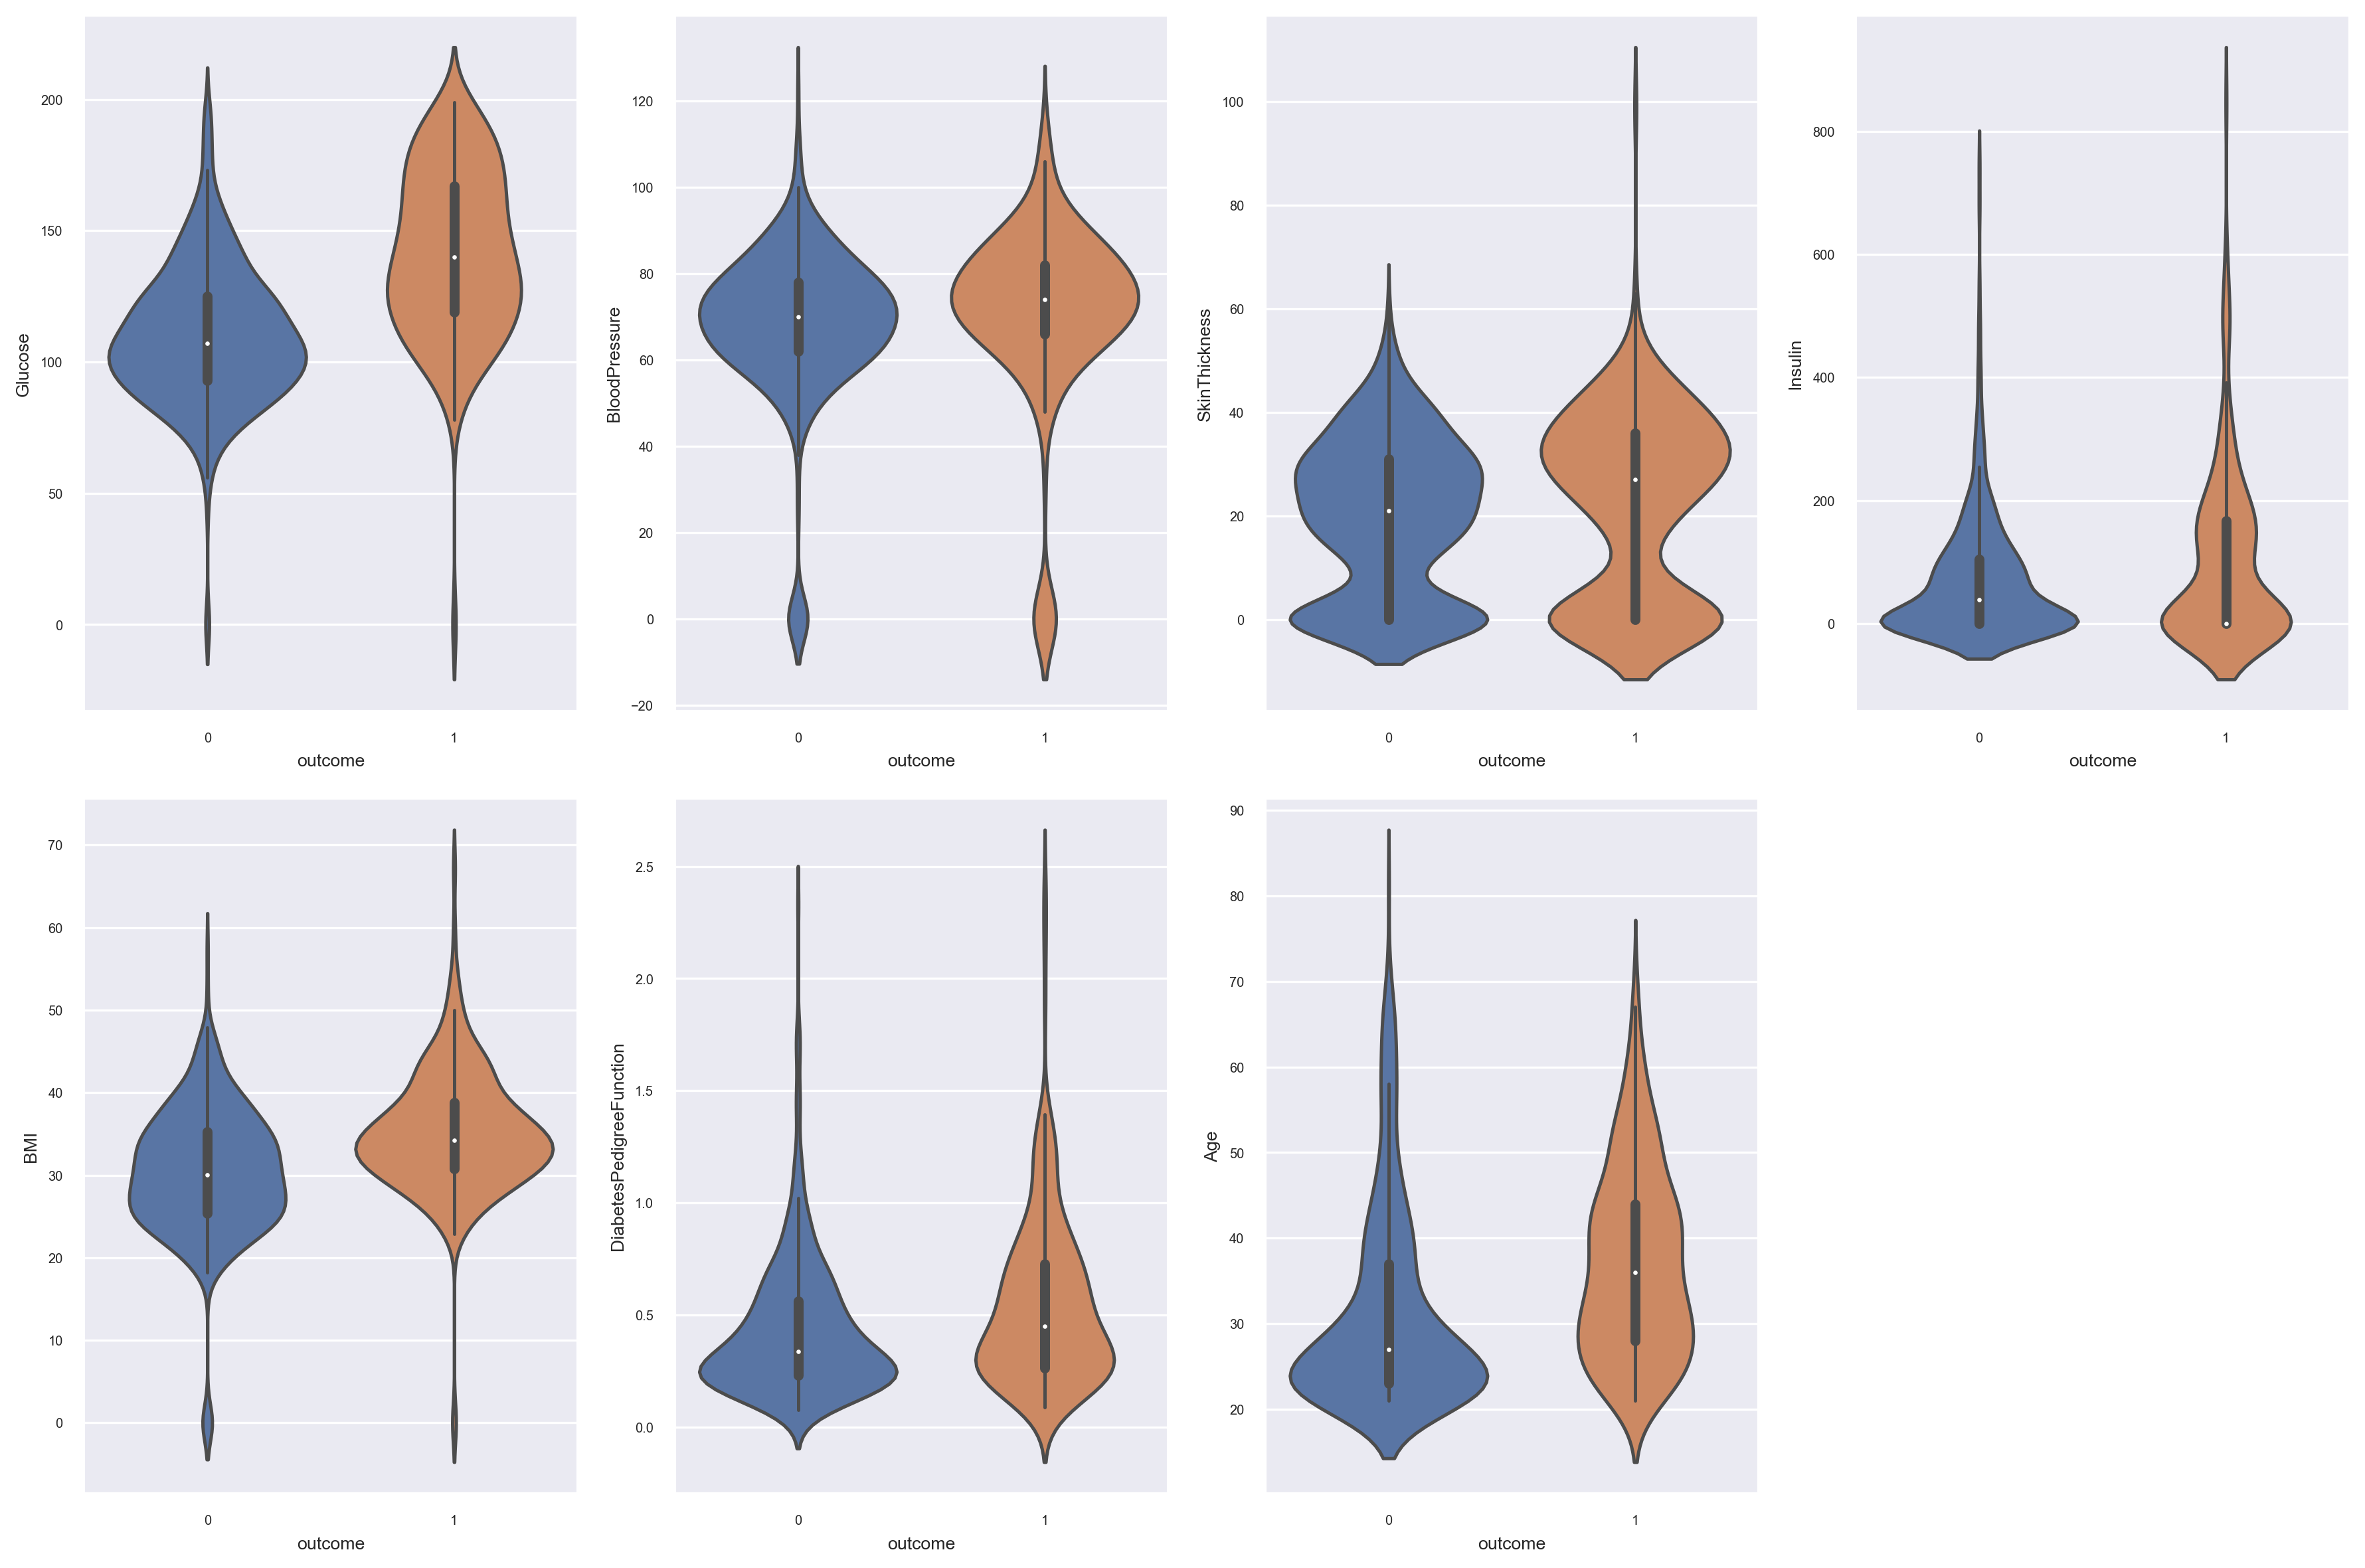

In [7]:
mpl.rc('axes', labelsize=7)
mpl.rc('xtick', labelsize=6)
mpl.rc('ytick', labelsize=6)
mpl.rc('figure', dpi=240)
plt.close('all')

features = list(input_df.columns[:])

feature_violin_plot = features[1:-1]

#set seaborn plotting aesthetics as default
sns.set()

fig, axes = plt.subplots(2, 4, figsize=(15,10))  

for i,ax in enumerate(axes.flat):
    if i < len(feature_violin_plot):
        ax.set_xlabel(ax.get_xlabel(), fontsize=8)
        ax.set_ylabel(ax.get_ylabel(), fontsize=8)
        ax.set_title(ax.get_title(), fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=6) 
        ax.autoscale(enable=True, axis='y', tight=False)
        sns.violinplot(data=input_df, x='outcome', y=feature_violin_plot[i], ax=ax)
    else:
            ax.set_visible(False)  # Hide extra axes that are not used

plt.tight_layout()
plt.show()

In [8]:
#Check for null value
print(input_df[input_df.isnull().any(axis=1)])
# input_df_no_na = input_df.dropna()

Empty DataFrame
Columns: [Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, outcome]
Index: []


# Check Rows With Zero Values and Make Imputation

In [9]:
print('Rows With 0 Value')
for col in input_df.columns:
    zero_rows = input_df.loc[input_df[col]==0].shape[0]
    print(col+": "+str(zero_rows))

Rows With 0 Value
Pregnancies: 111
Glucose: 5
BloodPressure: 35
SkinThickness: 227
Insulin: 374
BMI: 11
DiabetesPedigreeFunction: 0
Age: 0
outcome: 500


We can see that the glucose, BloodPressure, SkinThickness, Insulin, and BMI shouldn't be 0 for a normal people eventhough it is also classified as diabetic

In [10]:
# Replace 0 value with NaN
input_df.Glucose = input_df.Glucose.replace(0,np.nan)
input_df.BloodPressure = input_df.BloodPressure.replace(0,np.nan)
input_df.SkinThickness = input_df.SkinThickness.replace(0,np.nan)
input_df.Insulin = input_df.Insulin.replace(0,np.nan)
input_df.BMI = input_df.BMI.replace(0,np.nan)

In [11]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    float64
 1   Glucose                   763 non-null    float64
 2   BloodPressure             733 non-null    float64
 3   SkinThickness             541 non-null    float64
 4   Insulin                   394 non-null    float64
 5   BMI                       757 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    float64
 8   outcome                   768 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 54.1 KB


In [12]:
columns_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

df_inputed = input_df.copy()

# Create an imputer that will replace NaNs with the median of the column
imputer = SimpleImputer(strategy='median')
df_inputed[columns_with_zeros] = imputer.fit_transform(df_inputed[columns_with_zeros])

In [13]:
scaler = StandardScaler()

# Apply scaling to all features except the target 'Outcome'
features = df_inputed.drop('outcome', axis=1)  # Exclude the target column
scaled_features = scaler.fit_transform(features)

# Create a new DataFrame with scaled features
df_inputed_scaled = pd.DataFrame(scaled_features, columns=features.columns)

# Add the target column 'Outcome' back to the scaled DataFrame
df_inputed_scaled['outcome'] = df_inputed['outcome']
df_inputed_scaled

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,outcome
0,0.64,0.87,-0.03,0.67,-0.18,0.17,0.47,1.43,1
1,-0.84,-1.21,-0.53,-0.01,-0.18,-0.85,-0.37,-0.19,0
2,1.23,2.02,-0.69,-0.01,-0.18,-1.33,0.60,-0.11,1
3,-0.84,-1.07,-0.53,-0.70,-0.54,-0.63,-0.92,-1.04,0
4,-1.14,0.50,-2.68,0.67,0.32,1.55,5.48,-0.02,1
...,...,...,...,...,...,...,...,...,...
763,1.83,-0.68,0.30,2.15,0.46,0.06,-0.91,2.53,0
764,-0.55,0.01,-0.20,-0.24,-0.18,0.63,-0.40,-0.53,0
765,0.34,-0.02,-0.03,-0.70,-0.33,-0.91,-0.69,-0.28,0
766,-0.84,0.14,-1.02,-0.01,-0.18,-0.34,-0.37,1.17,1


In [14]:
print(df_inputed_scaled[df_inputed_scaled.isnull().any(axis=1)])
for col in df_inputed_scaled.columns:
    zero_rows = df_inputed_scaled.loc[df_inputed_scaled[col]==0].shape[0]
    print(col+": "+str(zero_rows))

Empty DataFrame
Columns: [Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, outcome]
Index: []
Pregnancies: 0
Glucose: 0
BloodPressure: 0
SkinThickness: 0
Insulin: 0
BMI: 0
DiabetesPedigreeFunction: 0
Age: 0
outcome: 500


In [15]:
df_inputed_scaled.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,outcome
count,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00
mean,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.35
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.48
min,-1.14,-2.55,-4.00,-2.52,-1.47,-2.07,-1.19,-1.04,0.00
25%,-0.84,-0.72,-0.69,-0.47,-0.22,-0.72,-0.69,-0.79,0.00
50%,-0.25,-0.15,-0.03,-0.01,-0.18,-0.02,-0.30,-0.36,0.00
75%,0.64,0.61,0.63,0.33,-0.16,0.60,0.47,0.66,1.00
max,3.91,2.54,4.10,7.96,8.17,5.04,5.88,4.06,1.00


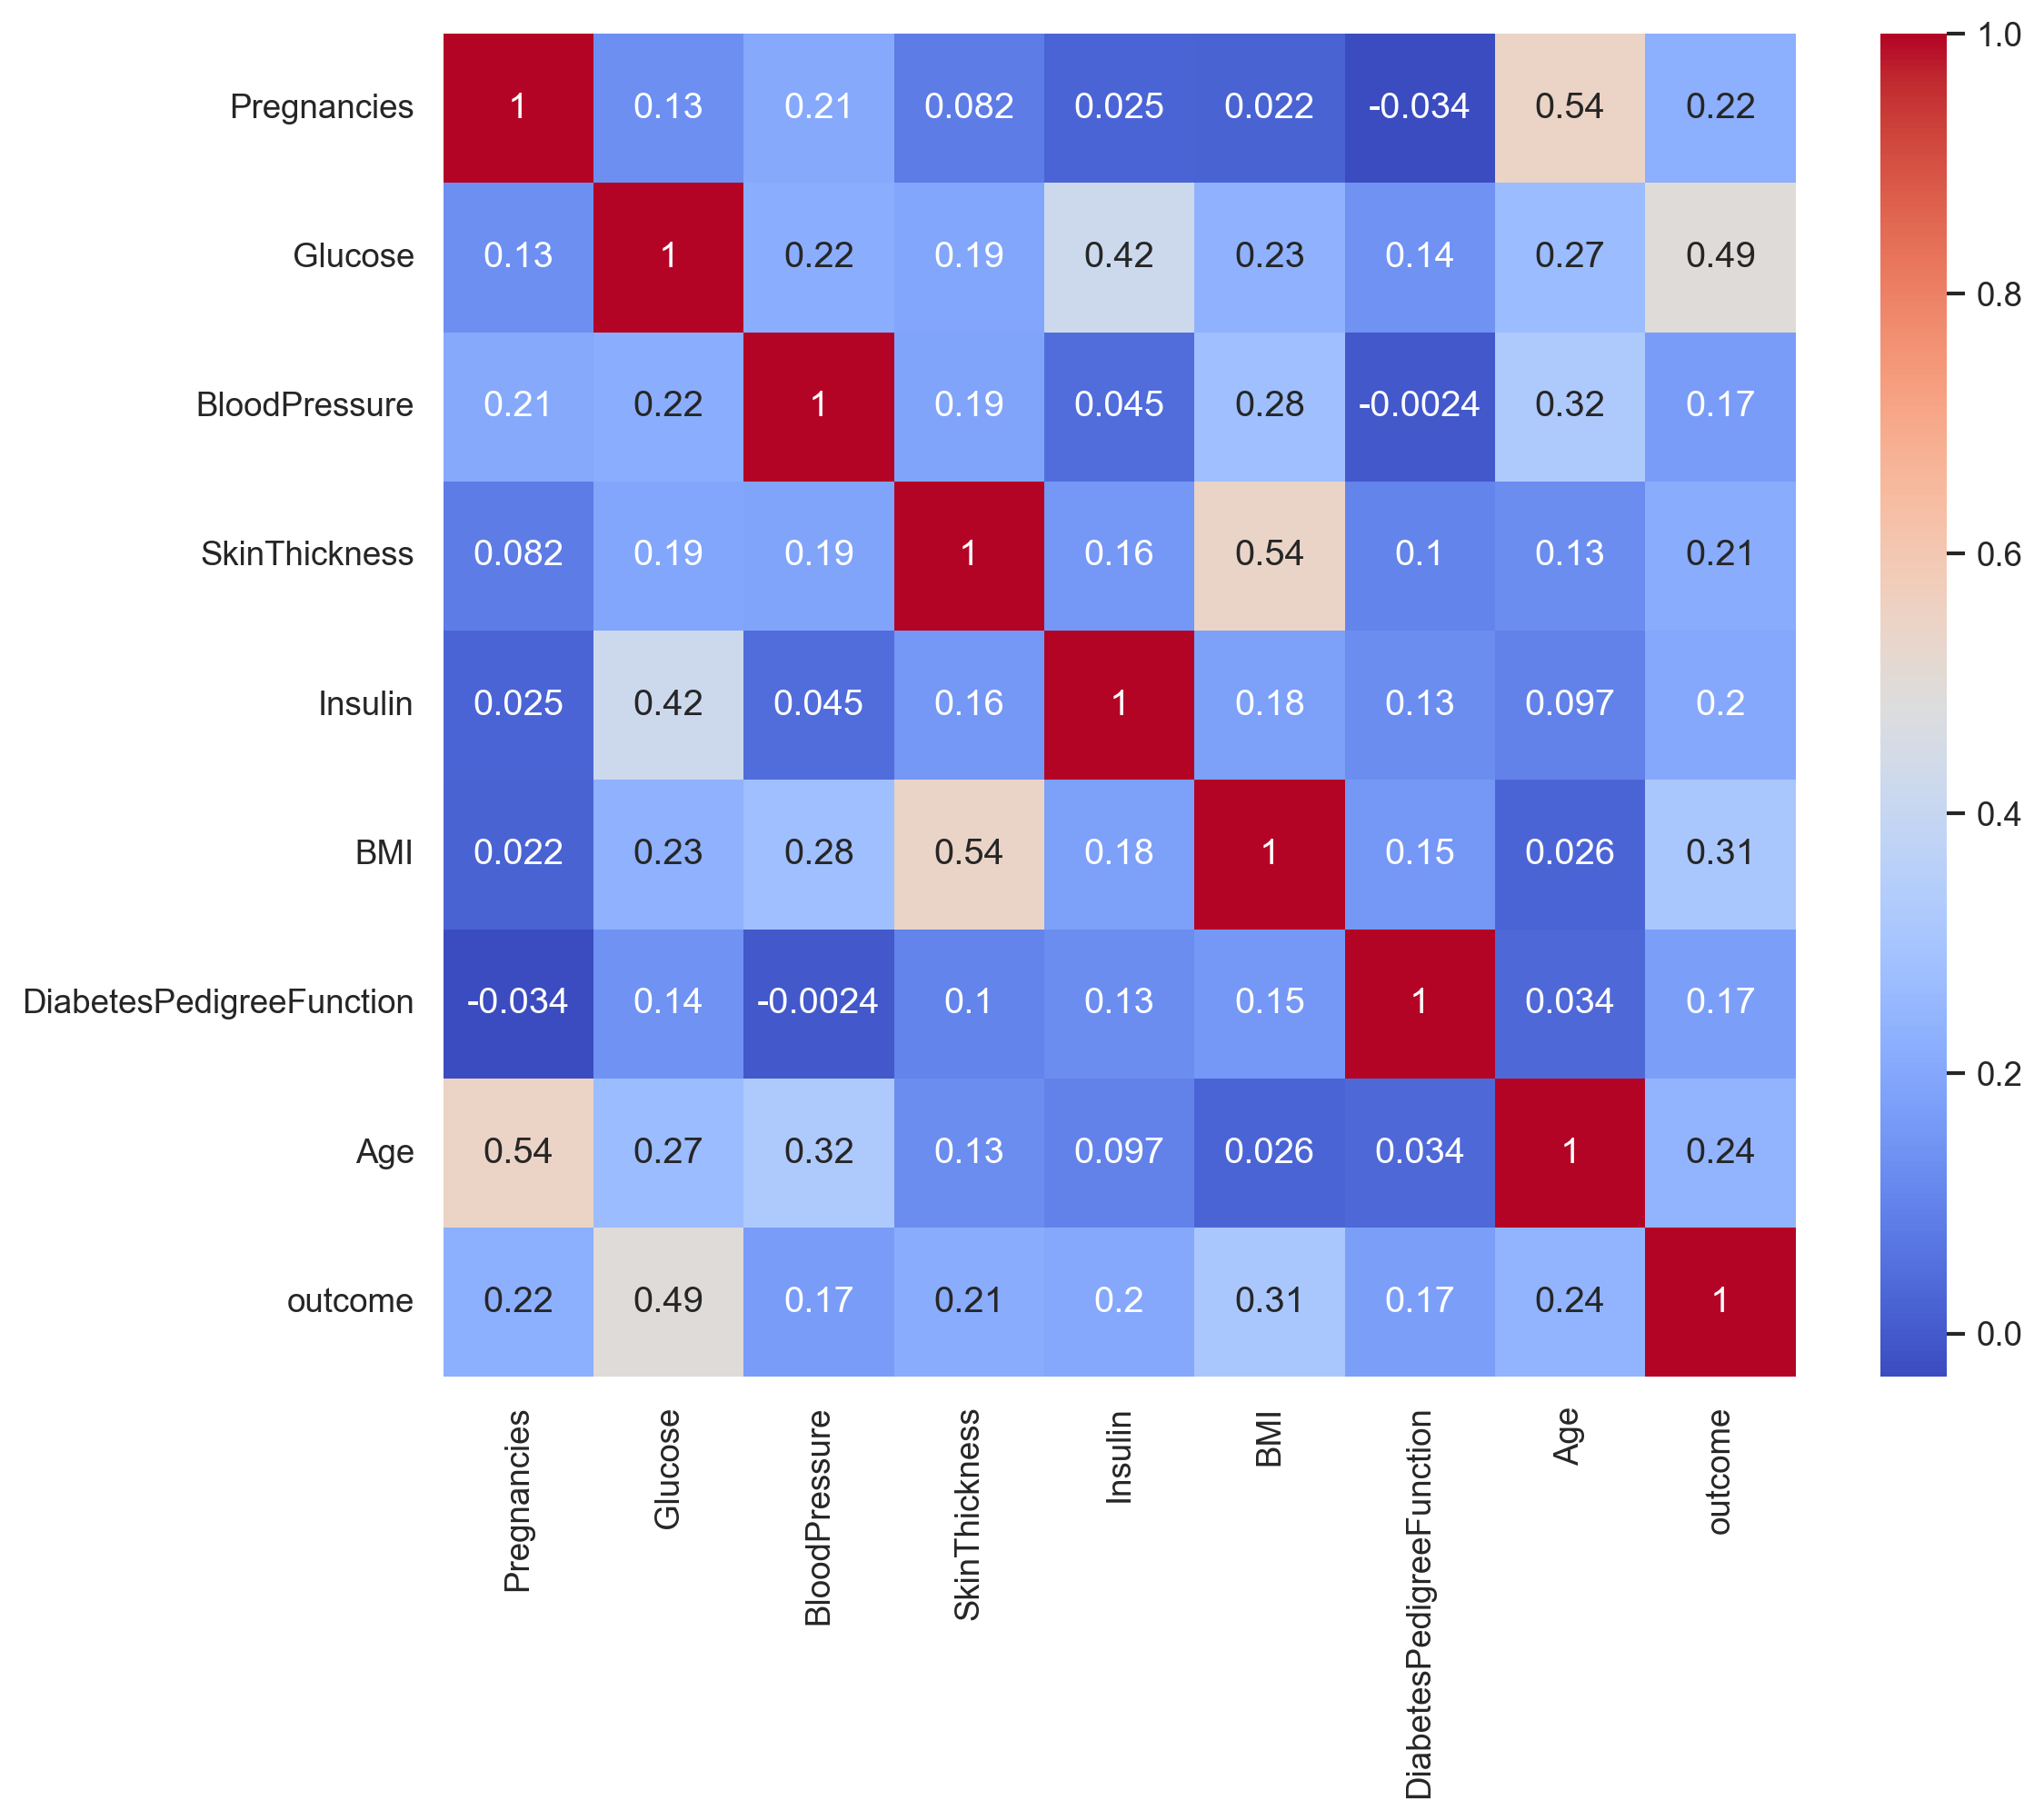

Correlation Value: 


outcome                    1.00
Glucose                    0.49
BMI                        0.31
Age                        0.24
Pregnancies                0.22
SkinThickness              0.21
Insulin                    0.20
DiabetesPedigreeFunction   0.17
BloodPressure              0.17
Name: outcome, dtype: float64

In [16]:
corr = df_inputed_scaled.corr()

# Plot heatmap of correlations with Outcome
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.savefig('correlation_matrix.jpg', format='jpg', dpi=600)
plt.show()

print("Correlation Value: ")
corr_with_outcome_sorted = corr['outcome'].sort_values(ascending=False)
corr_with_outcome_sorted

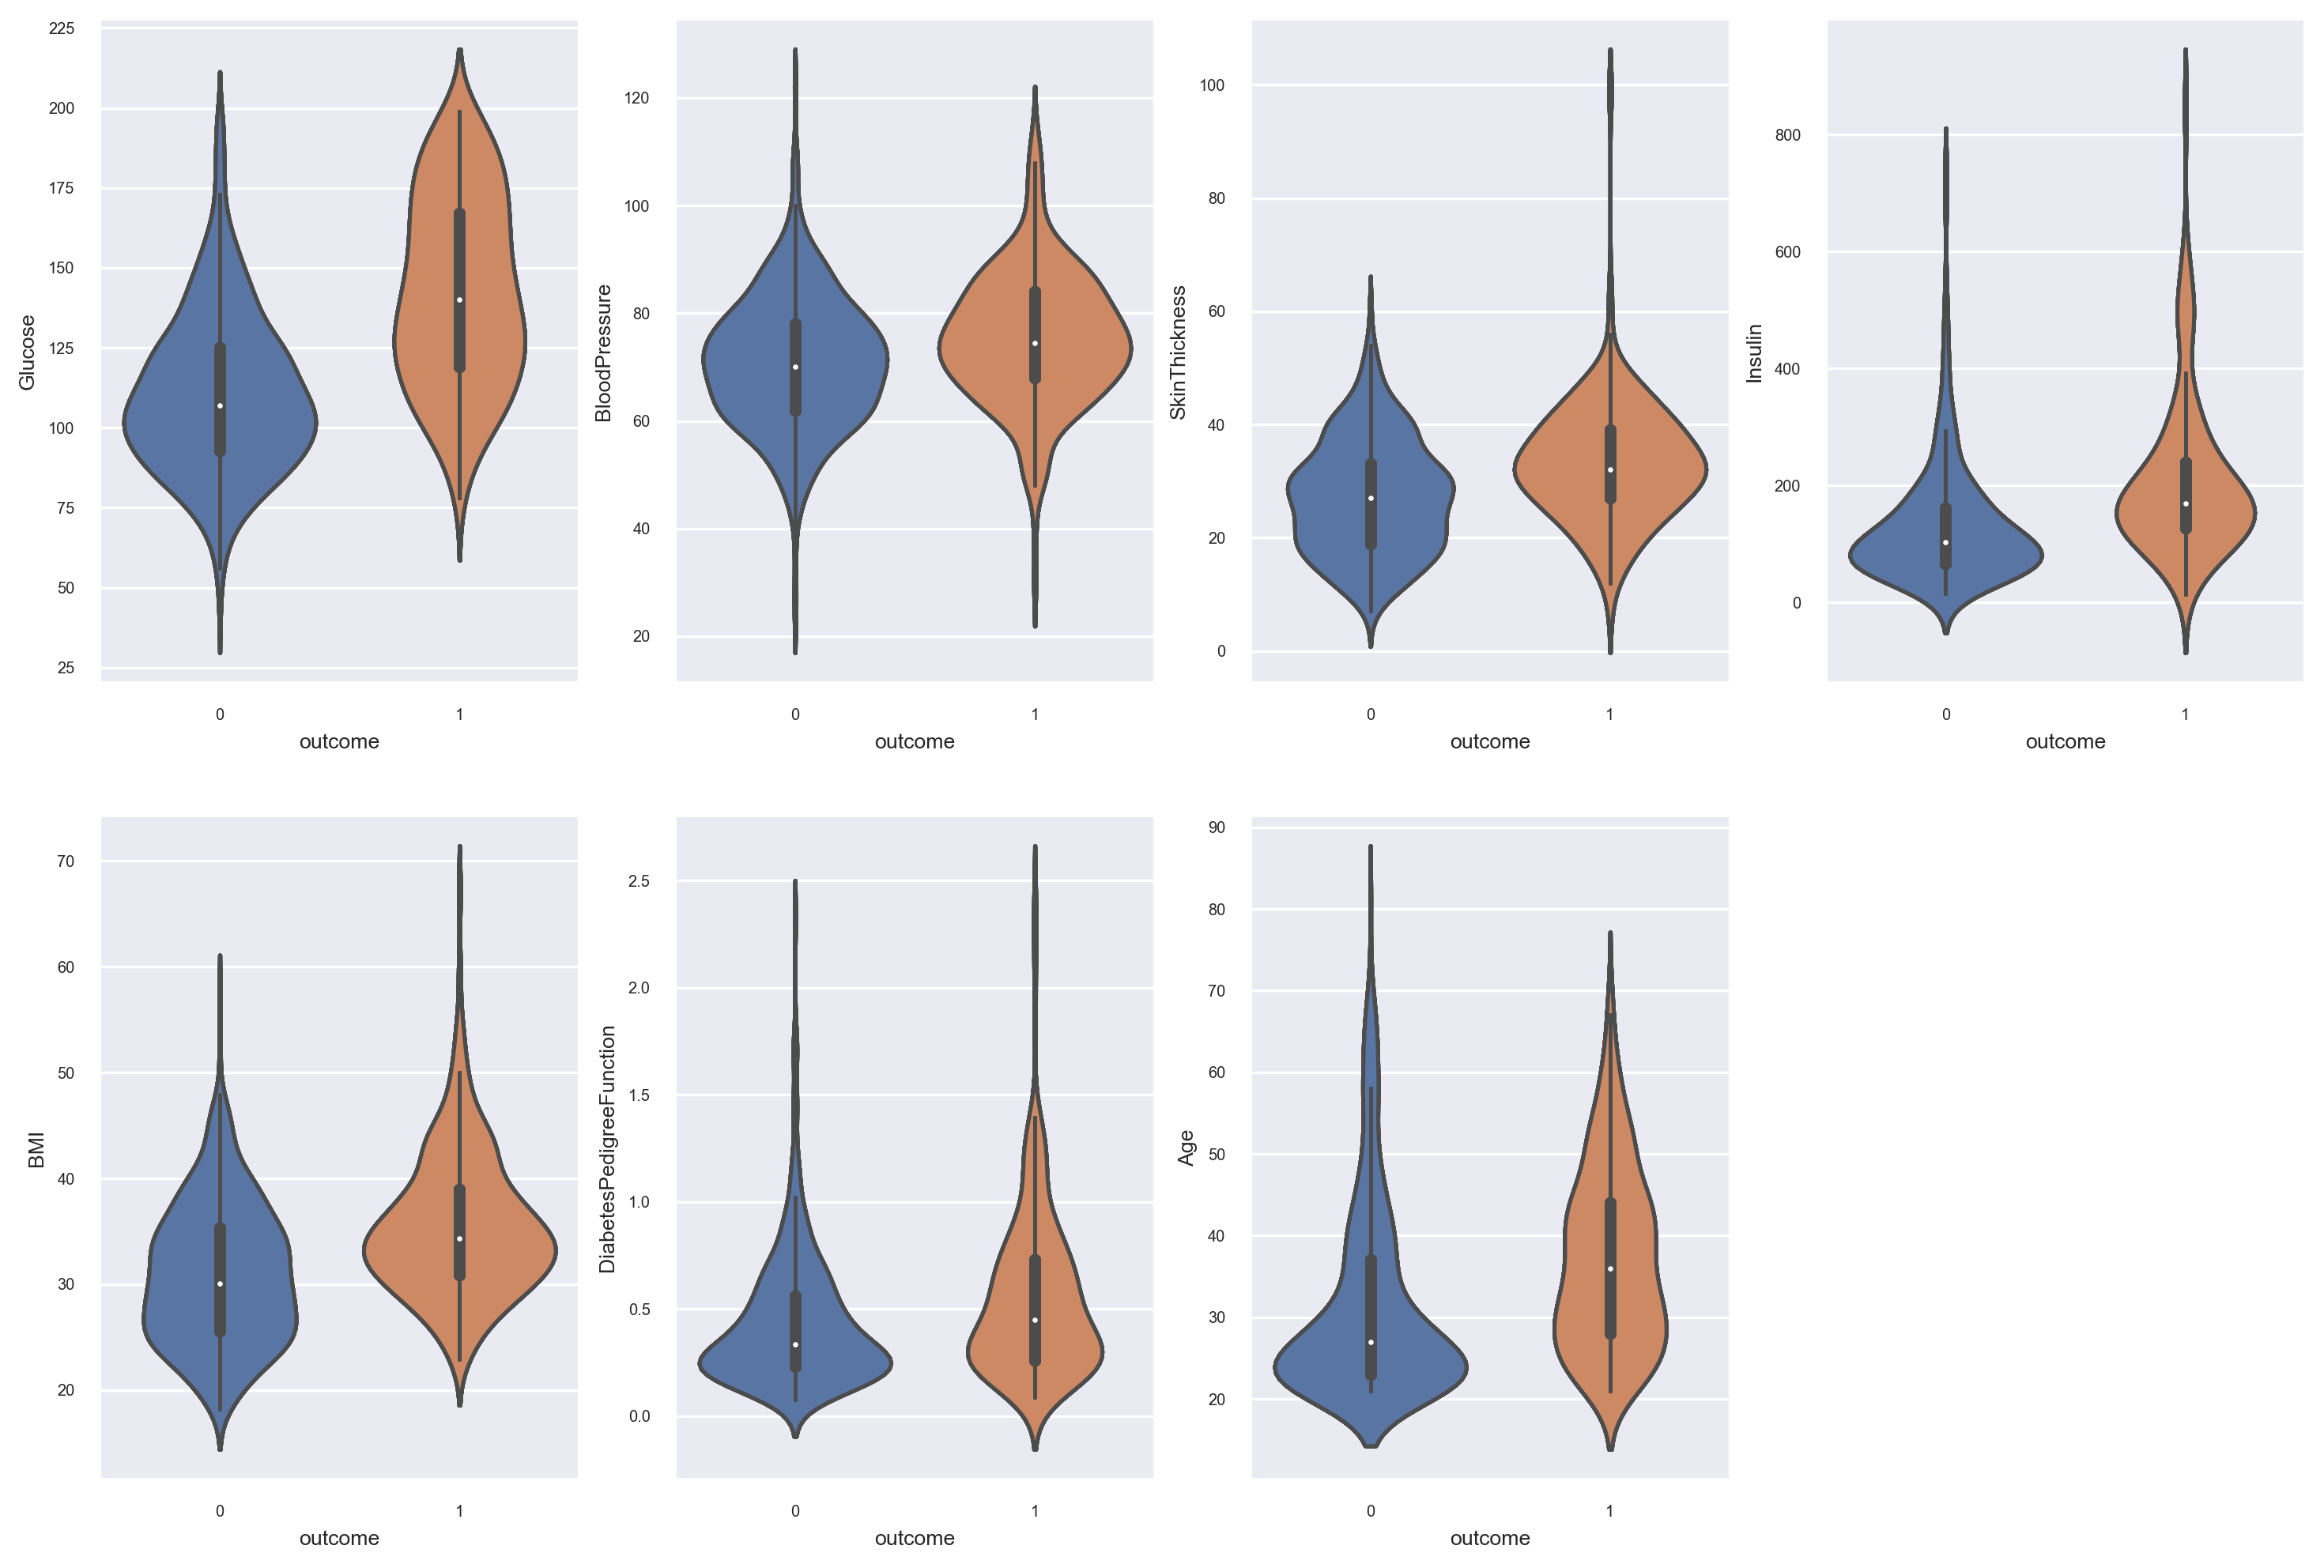

In [17]:
fig, axes = plt.subplots(2, 4, figsize=(15,10))  

for i,ax in enumerate(axes.flat):
    for i, ax in enumerate(axes.flat):
        if i < len(feature_violin_plot):
            ax.set_xlabel(ax.get_xlabel(), fontsize=8)
            ax.set_ylabel(ax.get_ylabel(), fontsize=8)
            ax.set_title(ax.get_title(), fontsize=10)
            ax.tick_params(axis='both', which='major', labelsize=6) 
            ax.autoscale(enable=True, axis='y', tight=False)
            sns.violinplot(data=input_df, x='outcome', y=feature_violin_plot[i], ax=ax)
        else:
            ax.set_visible(False)  # Hide extra axes that are not used

# Convert data into array

In [18]:
arr_dataset = df_inputed_scaled.values
arr_dataset

array([[ 0.63994726,  0.86604475, -0.03198993, ...,  0.46849198,
         1.4259954 ,  1.        ],
       [-0.84488505, -1.20506583, -0.5283186 , ..., -0.36506078,
        -0.19067191,  0.        ],
       [ 1.23388019,  2.01666174, -0.69376149, ...,  0.60439732,
        -0.10558415,  1.        ],
       ...,
       [ 0.3429808 , -0.02157407, -0.03198993, ..., -0.68519336,
        -0.27575966,  0.        ],
       [-0.84488505,  0.14279979, -1.02464727, ..., -0.37110101,
         1.17073215,  1.        ],
       [-0.84488505, -0.94206766, -0.19743282, ..., -0.47378505,
        -0.87137393,  0.        ]])

# Split Data into Training, Testing, and Validation

In [19]:
X = arr_dataset[:,0:8]
y = arr_dataset[:,8]

print(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train_fit, X_train_validation, y_train_fit, y_train_validation = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=42)

[[ 0.63994726  0.86604475 -0.03198993 ...  0.16661909  0.46849198
   1.4259954 ]
 [-0.84488505 -1.20506583 -0.5283186  ... -0.85219977 -0.36506078
  -0.19067191]
 [ 1.23388019  2.01666174 -0.69376149 ... -1.33250037  0.60439732
  -0.10558415]
 ...
 [ 0.3429808  -0.02157407 -0.03198993 ... -0.91041786 -0.68519336
  -0.27575966]
 [-0.84488505  0.14279979 -1.02464727 ... -0.34279019 -0.37110101
   1.17073215]
 [-0.84488505 -0.94206766 -0.19743282 ... -0.29912651 -0.47378505
  -0.87137393]]


# Transform data by inpute the missing nan with median and scale the data

In [20]:
# Transform data by inpute the missing nan with median and scale the data
data_transform_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Impute missing values with median
    ('scaler', StandardScaler())  # Standardize the features
])

X_train_fit = data_transform_pipeline.fit_transform(X_train_fit)
X_train_validation = data_transform_pipeline.transform(X_train_validation)
X_test = data_transform_pipeline.transform(X_test)

# Function to Plot Loss and Accuracy per Epoch

In [21]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            smoothed_points.append(smoothed_points[-1] * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Plotting function
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Apply smoothing to the data
    smoothed_loss = smooth_curve(history['loss'])
    smoothed_val_loss = smooth_curve(history['val_loss'])
    smoothed_accuracy = smooth_curve(history['accuracy'])
    smoothed_val_accuracy = smooth_curve(history['val_accuracy'])

    # Plot loss on the first subplot (ax1)
    ax1.plot(smoothed_loss, label='Train Loss', color='tab:red')
    ax1.plot(smoothed_val_loss, label='Val Loss', color='tab:orange')
    ax1.set_title('Loss Over Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot accuracy on the second subplot (ax2)
    ax2.plot(smoothed_accuracy, label='Train Accuracy', color='tab:blue')
    ax2.plot(smoothed_val_accuracy, label='Val Accuracy', color='tab:green')
    ax2.set_title('Accuracy Over Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Create Single Layer Neural Network

In [22]:
class HistoryCallback(Callback):
    def on_train_begin(self, logs=None):
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        for key, value in logs.items():
            if key not in self.history:
                self.history[key] = []
            self.history[key].append(value)

history_callback = HistoryCallback()

In [23]:
def single_layer_nn(optimizer=keras.optimizers.Adam, learning_rate=0.0001, activation='sigmoid'):
    model = keras.models.Sequential()

    # Input layer
    model.add(keras.layers.Input(shape=(8,)))
    
    # Output Layer
    model.add(keras.layers.Dense(1, activation=activation))
    
    # Compile the model
    model.compile(loss="binary_crossentropy", 
                  optimizer=optimizer(learning_rate=learning_rate), 
                  metrics=["accuracy"])
    return model

# Early stopping and learning rate scheduler callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Create a pipeline
SingleNNPipeline = Pipeline([
    # ('imputation', SimpleImputer(missing_values=np.nan, strategy='median')),
    # ('scaling', StandardScaler()),
    ('model', KerasClassifier(model=single_layer_nn, verbose=1, callbacks=[early_stopping, history_callback]))
])

In [24]:
single_layer_nn().summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9 (36.00 B)

 Trainable params: 9 (36.00 B)

 Non-trainable params: 0 (0.00 B)

In [25]:
history_single_layer_nn = SingleNNPipeline.fit(
                      X_train_fit, 
                      y_train_fit, 
                      model__epochs=500, 
                      model__validation_data=(X_train_validation, y_train_validation)
                     )

Epoch 1/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6270 - loss: 0.6599 - val_accuracy: 0.6179 - val_loss: 0.6633
Epoch 2/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5897 - loss: 0.6835 - val_accuracy: 0.6179 - val_loss: 0.6619
Epoch 3/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6040 - loss: 0.6924 - val_accuracy: 0.6179 - val_loss: 0.6605
Epoch 4/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6040 - loss: 0.6906 - val_accuracy: 0.6179 - val_loss: 0.6591
Epoch 5/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6388 - loss: 0.6518 - val_accuracy: 0.6179 - val_loss: 0.6577
Epoch 6/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6161 - loss: 0.6834 - val_accuracy: 0.6179 - val_loss: 0.6563
Epoch 7/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6028 - loss: 0.6787 - val_accuracy: 0.6260 - val_loss: 0.6549
Epoch 8/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6073 - loss: 0.6679 - val_accuracy: 0.6341 - 

In [26]:
# Look Result for Validation TestSet

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Accuracy 0.7967479674796748
Balanced Accuracy 0.7684593023255815
Recall 0.6744186046511628
Precision 0.725
AUC 0.7684593023255814
F1 Score 0.6987951807228916
F-beta (0.1) 0.7244620331437052
F-beta (10) 0.6748847926267281


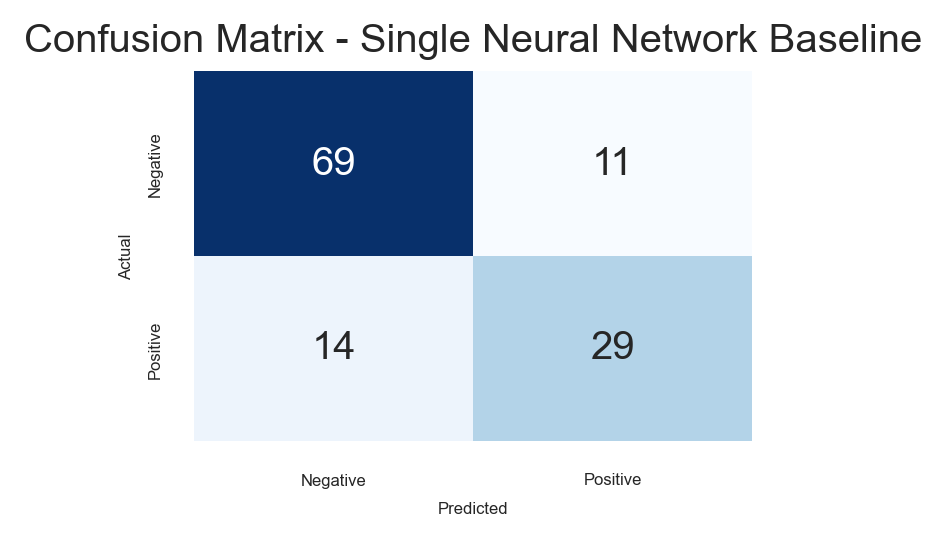

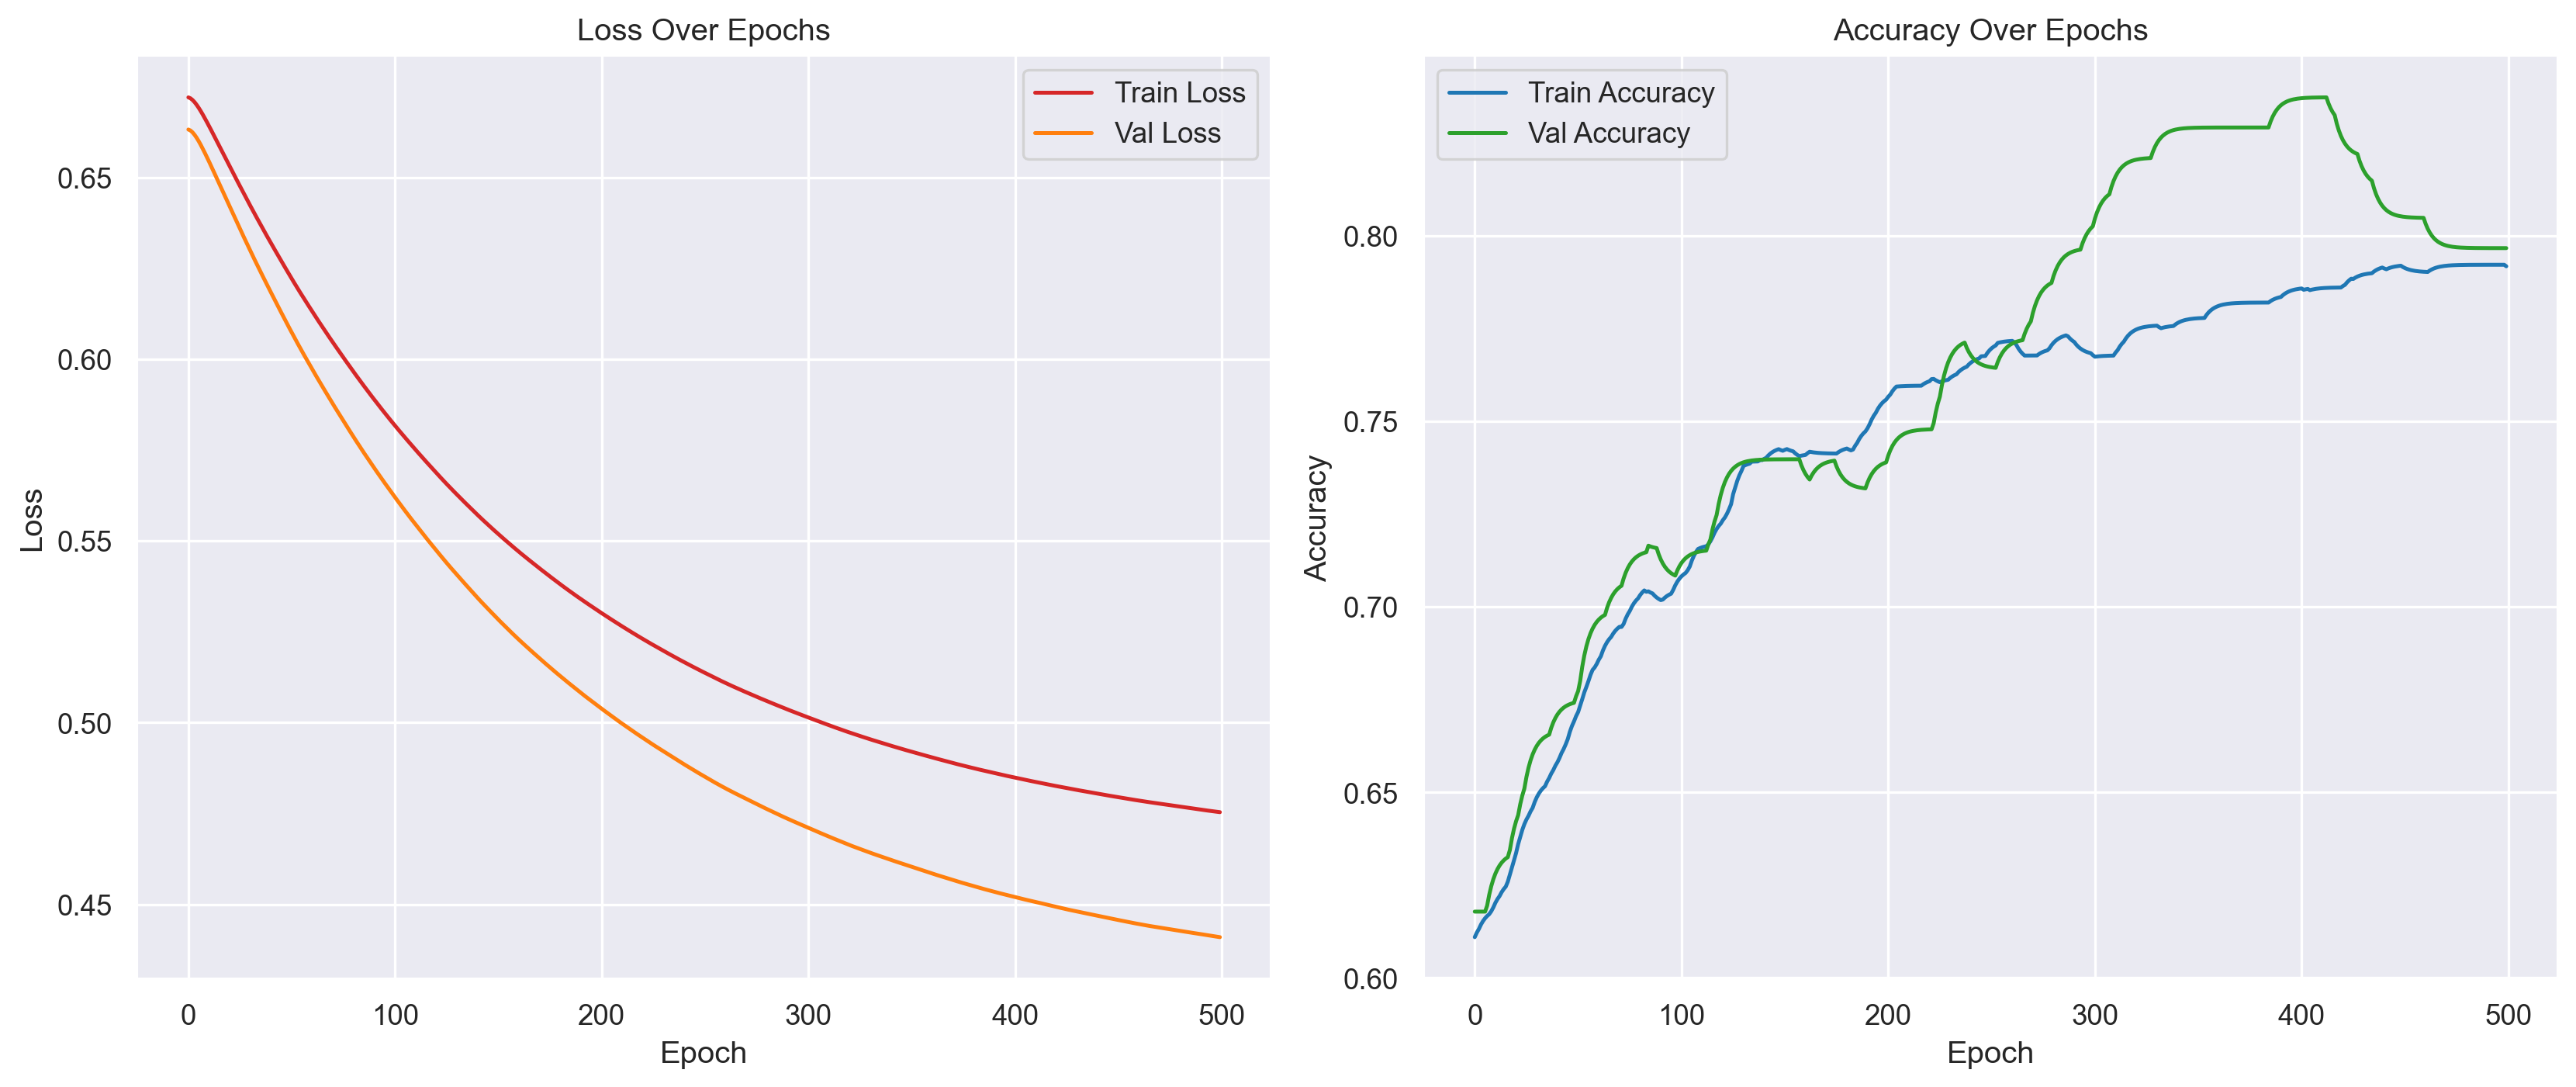

In [27]:
y_pred_base_single_nn = SingleNNPipeline.predict(X_train_validation)

accuracy_base_single_nn = accuracy_score(y_train_validation, y_pred_base_single_nn)
balanced_accuracy_base_single_nn = balanced_accuracy_score(y_train_validation, y_pred_base_single_nn)
recall_base_single_nn = recall_score(y_train_validation, y_pred_base_single_nn, pos_label=1)
precision_base_single_nn = precision_score(y_train_validation, y_pred_base_single_nn, pos_label=1)
auc_base_single_nn = roc_auc_score(pd.get_dummies(y_train_validation, drop_first=True), pd.get_dummies(y_pred_base_single_nn, drop_first=True))
f1_base_single_nn = f1_score(y_train_validation, y_pred_base_single_nn, pos_label=1)
fbeta_0_1_base_single_nn = fbeta_score(y_train_validation, y_pred_base_single_nn, beta=0.1, pos_label=1)
fbeta_10_base_single_nn = fbeta_score(y_train_validation, y_pred_base_single_nn, beta=10, pos_label=1)
conf_matrix_base_single_nn = confusion_matrix(y_train_validation, y_pred_base_single_nn)

print('Accuracy', accuracy_base_single_nn)
print('Balanced Accuracy', balanced_accuracy_base_single_nn)
print('Recall', recall_base_single_nn)
print('Precision', precision_base_single_nn)
print('AUC', auc_base_single_nn)
print('F1 Score', f1_base_single_nn)
print('F-beta (0.1)', fbeta_0_1_base_single_nn)
print('F-beta (10)', fbeta_10_base_single_nn)

# Plotting the confusion matrix
plt.figure(figsize=(3, 2))
sns.heatmap(conf_matrix_base_single_nn, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])

for text in ax.texts:
    text.set_size(5)
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
plt.xlabel('Predicted', fontsize=5)
plt.ylabel('Actual', fontsize=5)
plt.title('Confusion Matrix - Single Neural Network Baseline')
plt.show()

plot_history(history_callback.history)

# Hyperparameter Tunning for Single Layer Neural Network

In [28]:
if __name__ == "__main__":
    multiprocessing.set_start_method('fork', force=True)

    param_grid = {
        'model__model__optimizer': [keras.optimizers.Adam, keras.optimizers.SGD],  # Different optimizers to try
        'model__model__learning_rate': [0.001, 0.01, 0.1],  # Different learning rates
        'model__model__activation': ['sigmoid', 'relu'],  # Different activations
        'model__epochs': [500],  # Number of epochs
        'model__batch_size': [8, 16, 32]  # Different batch sizes,
    }
    
    tf.get_logger().setLevel('ERROR')
    
    # Define the grid search with cross-validation
    warnings.filterwarnings('ignore')
    warnings.simplefilter('ignore')
    grid_search_single_nn = GridSearchCV(estimator=SingleNNPipeline, param_grid=param_grid, n_jobs=-1, cv=3, scoring='f1', verbose = 3)
    
    # Assuming X_train and y_train are your training data
    # Fit the model with grid search
    grid_search_single_nn.fit(X_train_fit, y_train_fit, model__validation_data=(X_train_validation, y_train_validation), model__verbose=0)
    
    # Display the best hyperparameters and best score
    print("Best Hyperparameters Found: ", grid_search_single_nn.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[CV 1/3] END model__batch_size=8, model__epochs=500, model__model__activation=sigmoid, model__model__learning_rate=0.001, model__model__optimizer=<class 'keras.src.optimizers.sgd.SGD'>;, score=0.373 total time=   3.7s
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
[CV 3/3] END model__batch_size=8, model__epochs=500, model__model__activation=sigmoid, model__model__learning_rate=0.001, model__model__optimizer=<class 'keras.src.optimizers.sgd.SGD'>;, score=0.312 total time=   3.4s
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[CV 1/3] END model__batch_si

[CV 2/3] END model__batch_size=32, model__epochs=500, model__model__activation=sigmoid, model__model__learning_rate=0.001, model__model__optimizer=<class 'keras.src.optimizers.adam.Adam'>;, score=0.286 total time=   4.8s
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


[CV 3/3] END model__batch_size=32, model__epochs=500, model__model__activation=sigmoid, model__model__learning_rate=0.001, model__model__optimizer=<class 'keras.src.optimizers.sgd.SGD'>;, score=0.584 total time=   2.7s
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


[CV 1/3] END model__batch_size=32, model__epochs=500, model__model__activation=sigmoid, model__model__learning_rate=0.001, model__model__optimizer=<class 'keras.src.optimizers.sgd.SGD'>;, score=0.444 total time=   3.0s
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


[CV 1/3] END model__batch_size=32, model__epochs=500, model__model__activation=sigmoid, model__model__learning_rate=0.01, model__model__optimizer=<class 'keras.src.optimizers.adam.Adam'>;, score=0.222 total time=   3.0s
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


[CV 2/3] END model__batch_size=32, model__epochs=500, model__model__activation=sigmoid, model__model__learning_rate=0.01, model__model__optimizer=<class 'keras.src.optimizers.adam.Adam'>;, score=0.583 total time=   3.2s
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


[CV 3/3] END model__batch_size=32, model__epochs=500, model__model__activation=sigmoid, model__model__learning_rate=0.01, model__model__optimizer=<class 'keras.src.optimizers.adam.Adam'>;, score=0.657 total time=   3.2s
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step[CV 2/3] END model__batch_size=32, model__epochs=500, model__model__activation=sigmoid, model__model__learning_rate=0.001, model__model__optimizer=<class 'keras.src.optimizers.sgd.SGD'>;, score=0.578 total time=   2.7s
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[CV 2/3] END model__batch_size=32, model__epochs=500, model__model__activation=sigmoid, model__model__learning_rate=0.01, model__model__optimizer=<class 'keras.src.optimizers.sgd.SGD'>;, score=0.397 total time=   2.7s
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


[CV 1/3] END model__batch_size=32, model__epochs=500, model__model__activation=sigmoid, model__model__learning_rate=0.01, model__model__optimizer=<class 'keras.src.optimizers.sgd.SGD'>;, score=0.437 total time=   3.0s
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[CV 3/3] END model__batch_size=32, model__epochs=500, model__model__activation=sigmoid, model__model__learning_rate=0.01, model__model__optimizer=<class 'keras.src.optimizers.sgd.SGD'>;, score=0.567 total time=   2.7s
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


[CV 2/3] END model__batch_size=32, model__epochs=500, model__model__activation=sigmoid, model__model__learning_rate=0.1, model__model__optimizer=<class 'keras.src.optimizers.adam.Adam'>;, score=0.583 total time=   2.9s
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step[CV 1/3] END model__batch_size=32, model__epochs=500, model__model__activation=sigmoid, model__model__learning_rate=0.1, model__model__optimizer=<class 'keras.src.optimizers.sgd.SGD'>;, score=0.504 total time=   2.4s
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


[CV 3/3] END model__batch_size=32, model__epochs=500, model__model__activation=sigmoid, model__model__learning_rate=0.001, model__model__optimizer=<class 'keras.src.optimizers.adam.Adam'>;, score=0.647 total time=   3.8s
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[CV 3/3] END model__batch_size=32, model__epochs=500, model__model__activation=sigmoid, model__model__learning_rate=0.1, model__model__optimizer=<class 'keras.src.optimizers.sgd.SGD'>;, score=0.179 total time=   2.6s
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step[CV 3/3] END model__batch_size=32, model__epochs=500, model__model__activation=sigmoid, model__model__learning_rate=0.1, model__model__optimizer=<class 'keras.src.optimizers.adam.Adam'>;, score=0.704 total time=   4.3s
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[CV 3/3] END model__batch_size=32, model__epochs=500, model__model__activation=relu, model__model__learning_rate=0.001, model__model__optimizer=<class 'keras.src.optimizers.adam.Adam'>;, score=0.192 total time=   3.4s
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[CV 2/3] END model__batch_size=32, model__epochs=500, model__model__activation=relu, model__model__learning_rate=0.001, model__model__optimizer=<class 'keras.src.optimizers.adam.Adam'>;, score=0.328 total time=   3.7s
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
[CV 3/3] END model__batch_size=32, model__epochs=500, model__model__activation=relu, model__model__learning_rate=0.001, model__model__optimizer=<class 'keras.src.optimizers.sgd.SGD'>;, score=0.579 total time=   2.6s
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
[CV 1/3] END model__batch_size=32, model__epochs=500, model__model__activation=sigmoid, model__model__learning_rate=0.1, model__model__optimizer=<class 'keras.src.optimizers.adam.Adam'>;, score=0.629 total time=   6.4s
6/6 ━━━━━━━━━━━

[CV 2/3] END model__batch_size=32, model__epochs=500, model__model__activation=relu, model__model__learning_rate=0.01, model__model__optimizer=<class 'keras.src.optimizers.adam.Adam'>;, score=0.420 total time=   3.7s
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[CV 1/3] END model__batch_size=32, model__epochs=500, model__model__activation=relu, model__model__learning_rate=0.01, model__model__optimizer=<class 'keras.src.optimizers.sgd.SGD'>;, score=0.435 total time=   2.8s
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


[CV 2/3] END model__batch_size=32, model__epochs=500, model__model__activation=sigmoid, model__model__learning_rate=0.1, model__model__optimizer=<class 'keras.src.optimizers.sgd.SGD'>;, score=0.541 total time=   2.5s
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[CV 1/3] END model__batch_size=32, model__epochs=500, model__model__activation=relu, model__model__learning_rate=0.001, model__model__optimizer=<class 'keras.src.optimizers.adam.Adam'>;, score=0.483 total time=   3.1s
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[CV 1/3] END model__batch_size=32, model__epochs=500, model__model__activation=relu, model__model__learning_rate=0.001, model__model__optimizer=<class 'keras.src.optimizers.sgd.SGD'>;, score=0.333 total time=   2.7s
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[CV 2/3] END model__batch_size=32, model__epochs=500, model__model__activation=relu, model__model__learning_rate=0.001, model__model__optimizer=<class 'keras.src.optimizers.sgd.SGD'>;, score=0.475 total time=   2.6s
1/6 ━━━━━━━━━━━━━━━

In [38]:
""# Print the best score and parameters
print(f"Best params: {grid_search_single_nn.best_params_}")
print(f"Best score F1: {grid_search_single_nn.best_score_:.4f}")

# Evaluate the best model on the test set
best_model_single_nn = grid_search_single_nn.best_estimator_

Best params: {'model__batch_size': 32, 'model__epochs': 500, 'model__model__activation': 'sigmoid', 'model__model__learning_rate': 0.1, 'model__model__optimizer': <class 'keras.src.optimizers.adam.Adam'>}
Best score F1: 0.6383


# Evaluate Perceptron Model on Validation Train Set


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Perceptron Model Evaluation on Validation Train Set: 

Accuracy Perceptron Validation Train 0.8130081300813008
Balanced Accuracy Perceptron Validation Train 0.7755813953488373
Recall Perceptron Validation Train 0.6511627906976745
Precision Perceptron Validation Train 0.7777777777777778
AUC Perceptron Validation Train 0.7755813953488373
F1 Score Perceptron Validation Train 0.7088607594936709


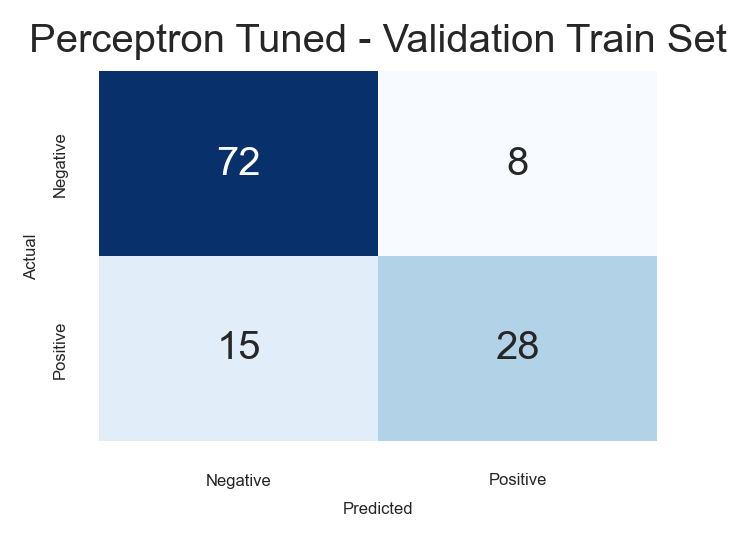

In [39]:
y_pred_best_model_single_nn = best_model_single_nn.predict(X_train_validation)

acc_best_model_single_nn_train = accuracy_score(y_train_validation, y_pred_best_model_single_nn)
balanced_accuracy_best_model_single_nn_train = balanced_accuracy_score(y_train_validation, y_pred_best_model_single_nn)
recall_best_model_single_nn_train = recall_score(y_train_validation, y_pred_best_model_single_nn, pos_label=1)
precision_best_model_single_nn_train = precision_score(y_train_validation, y_pred_best_model_single_nn, pos_label=1)
auc_best_model_single_nn_train = roc_auc_score(pd.get_dummies(y_train_validation, drop_first=True), pd.get_dummies(y_pred_best_model_single_nn, drop_first=True))
f1_best_model_single_nn_train = f1_score(y_train_validation, y_pred_best_model_single_nn, pos_label=1)
conf_matrix_best_model_single_nn_train = confusion_matrix(y_train_validation, y_pred_best_model_single_nn)

print("Perceptron Model Evaluation on Validation Train Set: ")
print("")
print('Accuracy Perceptron Validation Train', acc_best_model_single_nn_train)
print('Balanced Accuracy Perceptron Validation Train', balanced_accuracy_best_model_single_nn_train)
print('Recall Perceptron Validation Train', recall_best_model_single_nn_train)
print('Precision Perceptron Validation Train', precision_best_model_single_nn_train)
print('AUC Perceptron Validation Train', auc_best_model_single_nn_train)
print('F1 Score Perceptron Validation Train', f1_best_model_single_nn_train)

# Plotting the confusion matrix
plt.figure(figsize=(3, 2))
sns.heatmap(conf_matrix_best_model_single_nn_train, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])

for text in ax.texts:
    text.set_size(5)
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
plt.xlabel('Predicted', fontsize=5)
plt.ylabel('Actual', fontsize=5)
plt.title('Perceptron Tuned - Validation Train Set')
plt.show()

# Evaluate Perceptron Model on Test Set

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Perceptron Model Evaluation on Test Set: 

Accuracy Perceptron Test 0.7142857142857143
Balanced Accuracy Perceptron Test 0.6692592592592592
Recall Perceptron Test 0.5185185185185185
Precision Perceptron Test 0.6086956521739131
AUC Perceptron Test 0.6692592592592593
F1 Score Perceptron Test 0.56


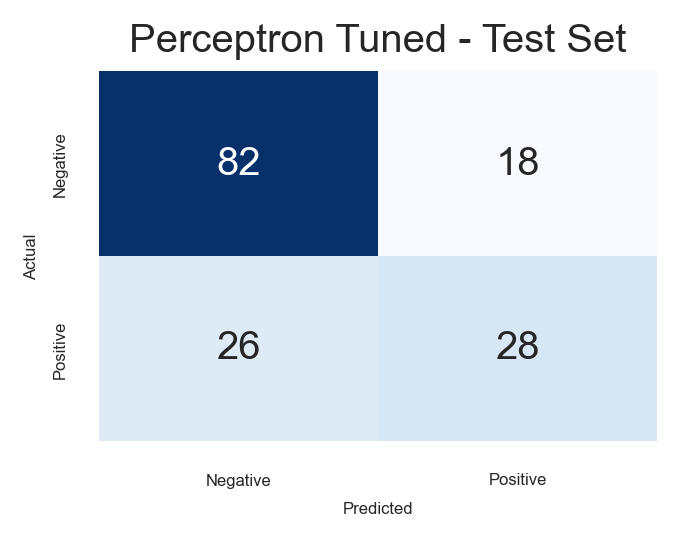

In [45]:
y_pred_best_model_single_nn_test = best_model_single_nn.predict(X_test)

acc_best_model_single_nn_test = accuracy_score(y_test, y_pred_best_model_single_nn_test)
balanced_accuracy_best_model_single_nn_test = balanced_accuracy_score(y_test, y_pred_best_model_single_nn_test)
recall_best_model_single_nn_test = recall_score(y_test, y_pred_best_model_single_nn_test, pos_label=1)
precision_best_model_single_nn_test = precision_score(y_test, y_pred_best_model_single_nn_test, pos_label=1)
auc_best_model_single_nn_test = roc_auc_score(pd.get_dummies(y_test, drop_first=True), pd.get_dummies(y_pred_best_model_single_nn_test, drop_first=True))
f1_best_model_single_nn_test = f1_score(y_test, y_pred_best_model_single_nn_test, pos_label=1)
conf_matrix_best_model_single_nn_test = confusion_matrix(y_test, y_pred_best_model_single_nn_test)

print("Perceptron Model Evaluation on Test Set: ")
print("")
print('Accuracy Perceptron Test', acc_best_model_single_nn_test)
print('Balanced Accuracy Perceptron Test', balanced_accuracy_best_model_single_nn_test)
print('Recall Perceptron Test', recall_best_model_single_nn_test)
print('Precision Perceptron Test', precision_best_model_single_nn_test)
print('AUC Perceptron Test', auc_best_model_single_nn_test)
print('F1 Score Perceptron Test', f1_best_model_single_nn_test)



# Plotting the confusion matrix
plt.figure(figsize=(3, 2))
sns.heatmap(conf_matrix_best_model_single_nn_test, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])

for text in ax.texts:
    text.set_size(5)
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
plt.xlabel('Predicted', fontsize=5)
plt.ylabel('Actual', fontsize=5)
plt.title('Perceptron Tuned - Test Set')
plt.show()

In [32]:
cv_results = grid_search_single_nn.cv_results_

# Convert cv_results_ to DataFrame
results_df = pd.DataFrame(cv_results)

# Display the relevant columns, e.g., mean test score, parameters, and rank
# results_df = results_df[['mean_test_score', 'std_test_score', 'params', 'rank_test_score']]
# results_df
sorted_result_gridsearch = results_df.sort_values(by='rank_test_score')
sorted_result_gridsearch.head(5)
# print(sorted_result_gridsearch['params'].head(5).to_string())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__batch_size,param_model__epochs,param_model__model__activation,param_model__model__learning_rate,param_model__model__optimizer,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
28,4.37,1.42,0.15,0.04,32,500,sigmoid,0.10,<class 'keras.src.optimizers.adam.Adam'>,"{'model__batch_size': 32, 'model__epochs': 500...",0.63,0.58,0.70,0.64,0.05,1
16,5.49,2.12,0.25,0.08,16,500,sigmoid,0.10,<class 'keras.src.optimizers.adam.Adam'>,"{'model__batch_size': 16, 'model__epochs': 500...",0.67,0.49,0.75,0.64,0.11,2
4,5.28,0.63,0.15,0.05,8,500,sigmoid,0.10,<class 'keras.src.optimizers.adam.Adam'>,"{'model__batch_size': 8, 'model__epochs': 500,...",0.65,0.51,0.73,0.63,0.09,3
5,6.64,1.35,0.28,0.06,8,500,sigmoid,0.10,<class 'keras.src.optimizers.sgd.SGD'>,"{'model__batch_size': 8, 'model__epochs': 500,...",0.64,0.55,0.69,0.63,0.06,4
35,2.28,0.10,0.14,0.03,32,500,relu,0.10,<class 'keras.src.optimizers.sgd.SGD'>,"{'model__batch_size': 32, 'model__epochs': 500...",0.60,0.61,0.63,0.61,0.01,5


In [33]:
sorted_results = results_df.sort_values(by='rank_test_score')
sorted_results
# tools.display_dataframe_to_user(name="Sorted GridSearchCV Results", dataframe=sorted_results)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__batch_size,param_model__epochs,param_model__model__activation,param_model__model__learning_rate,param_model__model__optimizer,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
28,4.37,1.42,0.15,0.04,32,500,sigmoid,0.10,<class 'keras.src.optimizers.adam.Adam'>,"{'model__batch_size': 32, 'model__epochs': 500...",0.63,0.58,0.70,0.64,0.05,1
16,5.49,2.12,0.25,0.08,16,500,sigmoid,0.10,<class 'keras.src.optimizers.adam.Adam'>,"{'model__batch_size': 16, 'model__epochs': 500...",0.67,0.49,0.75,0.64,0.11,2
4,5.28,0.63,0.15,0.05,8,500,sigmoid,0.10,<class 'keras.src.optimizers.adam.Adam'>,"{'model__batch_size': 8, 'model__epochs': 500,...",0.65,0.51,0.73,0.63,0.09,3
5,6.64,1.35,0.28,0.06,8,500,sigmoid,0.10,<class 'keras.src.optimizers.sgd.SGD'>,"{'model__batch_size': 8, 'model__epochs': 500,...",0.64,0.55,0.69,0.63,0.06,4
35,2.28,0.10,0.14,0.03,32,500,relu,0.10,<class 'keras.src.optimizers.sgd.SGD'>,"{'model__batch_size': 32, 'model__epochs': 500...",0.60,0.61,0.63,0.61,0.01,5
11,3.86,0.32,0.15,0.03,8,500,relu,0.10,<class 'keras.src.optimizers.sgd.SGD'>,"{'model__batch_size': 8, 'model__epochs': 500,...",0.64,0.46,0.69,0.60,0.10,6
2,5.24,2.16,0.25,0.06,8,500,sigmoid,0.01,<class 'keras.src.optimizers.adam.Adam'>,"{'model__batch_size': 8, 'model__epochs': 500,...",0.68,0.57,0.52,0.59,0.07,7
23,5.56,0.28,0.16,0.03,16,500,relu,0.10,<class 'keras.src.optimizers.sgd.SGD'>,"{'model__batch_size': 16, 'model__epochs': 500...",0.53,0.56,0.65,0.58,0.05,8
17,3.11,0.38,0.25,0.07,16,500,sigmoid,0.10,<class 'keras.src.optimizers.sgd.SGD'>,"{'model__batch_size': 16, 'model__epochs': 500...",0.55,0.59,0.59,0.58,0.02,9
22,7.14,0.26,0.15,0.02,16,500,relu,0.10,<class 'keras.src.optimizers.adam.Adam'>,"{'model__batch_size': 16, 'model__epochs': 500...",0.59,0.55,0.55,0.56,0.02,10


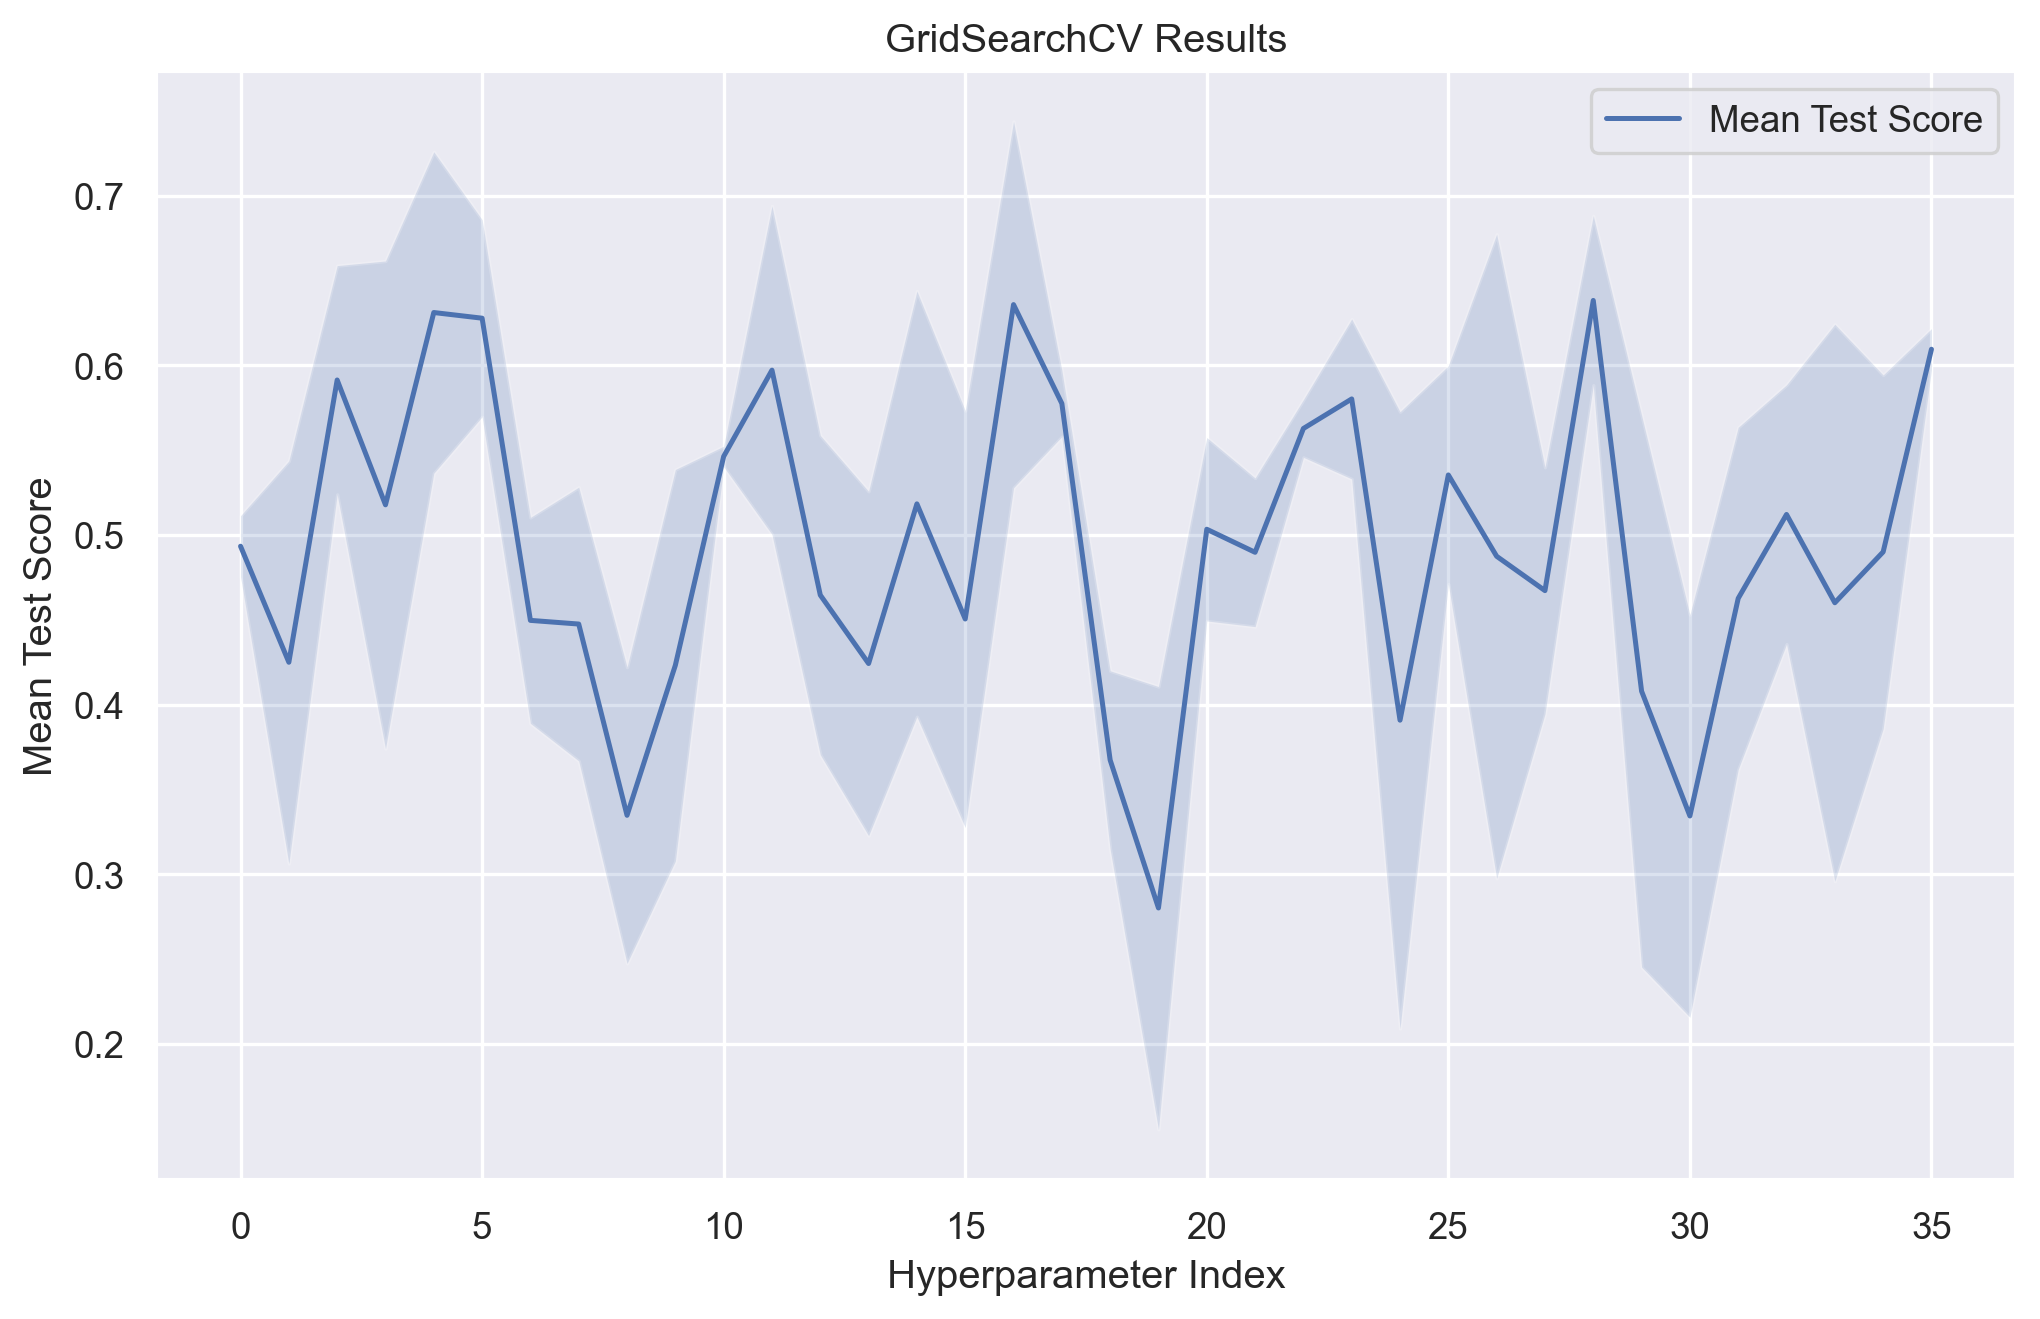

In [34]:
# Example: plotting mean_test_score for different parameter sets
plt.figure(figsize=(10, 6))
plt.plot(results_df['mean_test_score'], label='Mean Test Score')
plt.fill_between(range(len(results_df['mean_test_score'])),
                 results_df['mean_test_score'] - results_df['std_test_score'],
                 results_df['mean_test_score'] + results_df['std_test_score'], alpha=0.2)
plt.xlabel('Hyperparameter Index')
plt.ylabel('Mean Test Score')
plt.title('GridSearchCV Results')
plt.legend()
plt.show()

# Create Multi Layer Neural Network

# Base Model

In [35]:
def multi_layer_nn(optimizer=keras.optimizers.Adam, learning_rate=0.001, hidden_layers=(8,16),dropout_rate=0, activation='relu'):
    model = keras.models.Sequential()

    # Input layer
    model.add(keras.layers.Input(shape=(8,)))
    
    # Hidden layers
    for units in hidden_layers[1:]:
        model.add(keras.layers.Dense(units, activation=activation))
        model.add(keras.layers.Dropout(dropout_rate))
    
    # Compile the model
    model.compile(loss="binary_crossentropy", 
                  optimizer=optimizer(learning_rate=learning_rate), 
                  metrics=["accuracy"])
    
    # Output layer
    model.add(keras.layers.Dense(1, activation='sigmoid'))  # Binary classification
    # print(model.summary())
    
    return model

# Early stopping and learning rate scheduler callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Create a pipeline
MultiNNPipeline = Pipeline([
    ('model', KerasClassifier(model=multi_layer_nn, verbose=1, callbacks=[early_stopping]))
])

In [36]:
MultiNNPipeline.fit(X_train_fit, 
                      y_train_fit, 
                      model__epochs=500, 
                      model__validation_data=(X_train_validation, y_train_validation)
                     )

Epoch 1/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6879 - loss: 0.6506 - val_accuracy: 0.6585 - val_loss: 0.6407
Epoch 2/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7140 - loss: 0.5923 - val_accuracy: 0.6504 - val_loss: 0.6040
Epoch 3/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6759 - loss: 0.6219 - val_accuracy: 0.6585 - val_loss: 0.5748
Epoch 4/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7108 - loss: 0.5804 - val_accuracy: 0.7154 - val_loss: 0.5522
Epoch 5/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7175 - loss: 0.5668 - val_accuracy: 0.7236 - val_loss: 0.5332
Epoch 6/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7352 - loss: 0.5386 - val_accuracy: 0.7317 - val_loss: 0.5168
Epoch 7/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7307 - loss: 0.5402 - val_accuracy: 0.7398 - val_loss: 0.5032
Epoch 8/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7309 - loss: 0.5277 - val_accuracy: 0.

Pipeline(steps=[('model',
                 KerasClassifier(callbacks=[<keras.src.callbacks.early_stopping.EarlyStopping object at 0x354dbf590>], model=<function multi_layer_nn at 0x3601e63e0>))])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Accuracy: 0.8048780487804879
Balanced Accuracy 0.7747093023255813
Recall 0.6744186046511628
Precision 0.7435897435897436
AUC 0.7747093023255813
F1 Score 0.7073170731707317


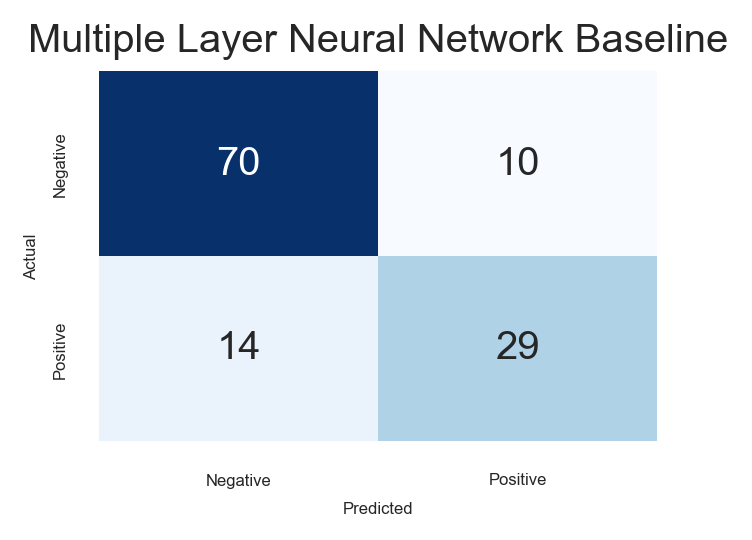

In [37]:
y_pred_multi_nn_base_train = MultiNNPipeline.predict(X_train_validation)
acc_multi_nn_base_train = accuracy_score(y_train_validation, y_pred_multi_nn_base_train)
balanced_accuracy_multi_nn_base_train = balanced_accuracy_score(y_train_validation, y_pred_multi_nn_base_train)
recall_multi_nn_base_train = recall_score(y_train_validation, y_pred_multi_nn_base_train, pos_label=1)
precision_multi_nn_base_train = precision_score(y_train_validation, y_pred_multi_nn_base_train, pos_label=1)
auc_multi_nn_base_train = roc_auc_score(pd.get_dummies(y_train_validation, drop_first=True), pd.get_dummies(y_pred_multi_nn_base_train, drop_first=True))
f1_multi_nn_base_train = f1_score(y_train_validation, y_pred_multi_nn_base_train, pos_label=1)
# fbeta_0_1 = fbeta_score(y_train_validation, y_pred_base_multi_nn, beta=0.1, pos_label=1)
# fbeta_10 = fbeta_score(y_train_validation, y_pred_base_multi_nn, beta=10, pos_label=1)
conf_matrix_multi_nn_base_train = confusion_matrix(y_train_validation, y_pred_multi_nn_base_train)

print(f'Accuracy: {acc_multi_nn_base_train}')
print('Balanced Accuracy', balanced_accuracy_multi_nn_base_train)
print('Recall', recall_multi_nn_base_train)
print('Precision', precision_multi_nn_base_train)
print('AUC', auc_multi_nn_base_train)
print('F1 Score', f1_multi_nn_base_train)
# print('F-beta (0.1)', fbeta_0_1_multi_nn_base_train)
# print('F-beta (10)', fbeta_10_multi_nn_base_train)

# Plotting the confusion matrix
plt.figure(figsize=(3, 2))
sns.heatmap(conf_matrix_multi_nn_base_train, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])

for text in ax.texts:
    text.set_size(5)
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
plt.xlabel('Predicted', fontsize=5)
plt.ylabel('Actual', fontsize=5)
plt.title('Multiple Layer Neural Network Baseline')
plt.show()

# Hyperparameter Tunning for Multi Layer Neural Network

In [40]:
if __name__ == "__main__":
    multiprocessing.set_start_method('fork', force=True)

    param_grid = {
        'model__model__optimizer': [keras.optimizers.Adam, keras.optimizers.SGD],  # Different optimizers to try
        'model__model__learning_rate': [0.0001, 0.001, 0.01, 0.1],
        'model__model__hidden_layers': [(32,16), (32,16,8)],  # Different layer architectures
        'model__model__dropout_rate': [0, 0.1, 0.2],
        'model__model__activation': ['sigmoid', 'relu'],
        'model__epochs': [100],  # Number of epochs
        'model__batch_size': [16, 32, 64]  # Batch sizes
    }
    
    # Define the grid search with cross-validation
    warnings.filterwarnings('ignore')
    warnings.simplefilter('ignore')
    grid_search_multi = GridSearchCV(estimator=MultiNNPipeline, param_grid=param_grid, n_jobs=2, cv=[(slice(None), slice(None))], scoring='f1', verbose = 3)
    
    # Assuming X_train and y_train are your training data
    # Fit the model with grid search
    grid_search_multi.fit(X_train_fit, y_train_fit, model__validation_data=(X_train_validation, y_train_validation), model__verbose=0)
    
    # Display the best hyperparameters and best score
    print("Best Hyperparameters: ", grid_search_multi.best_params_)
    print("Best Score: ", grid_search_multi.best_score_)

[CV 2/3] END model__batch_size=32, model__epochs=500, model__model__activation=relu, model__model__learning_rate=0.01, model__model__optimizer=<class 'keras.src.optimizers.sgd.SGD'>;, score=0.273 total time=   2.8s
[CV 2/3] END model__batch_size=32, model__epochs=500, model__model__activation=relu, model__model__learning_rate=0.1, model__model__optimizer=<class 'keras.src.optimizers.adam.Adam'>;, score=0.463 total time=   5.5s
[CV 3/3] END model__batch_size=32, model__epochs=500, model__model__activation=relu, model__model__learning_rate=0.01, model__model__optimizer=<class 'keras.src.optimizers.sgd.SGD'>;, score=0.673 total time=   2.8s
[CV 3/3] END model__batch_size=32, model__epochs=500, model__model__activation=relu, model__model__learning_rate=0.1, model__model__optimizer=<class 'keras.src.optimizers.adam.Adam'>;, score=0.629 total time=   3.2s
[CV 1/3] END model__batch_size=32, model__epochs=500, model__model__activation=relu, model__model__learning_rate=0.1, model__model__optimi

[CV 1/1] END model__batch_size=64, model__epochs=100, model__model__activation=sigmoid, model__model__dropout_rate=0, model__model__hidden_layers=(32, 16), model__model__learning_rate=0.0001, model__model__optimizer=<class 'keras.src.optimizers.sgd.SGD'>;, score=0.534 total time=   1.0s
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[CV 1/1] END model__batch_size=64, model__epochs=100, model__model__activation=sigmoid, model__model__dropout_rate=0, model__model__hidden_layers=(32, 16), model__model__learning_rate=0.0001, model__model__optimizer=<class 'keras.src.optimizers.adam.Adam'>;, score=0.056 total time=   1.4s
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[CV 1/1] END model__batch_size=64, model__epochs=100, model__model__activation=sigmoid, model__model__dropout_rate=0, model__model__hidden_layers=(32, 16), model__model__learning_rate=0.001, model__model__optimizer=<class 'keras.src.optimizers.adam.Adam'>;, score=0.517 total time=   1.2s
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[CV 1/1] END model__batch_size=64, model__epochs=100, model__model__activation=sigmoid, model__model__dropout_rate=0, model__model__hidden_layers=(32, 16), model__model__learning_rate=0.001, model__model__optimizer=<class 'keras.src.optimizers.sgd.SGD'>;, score=0.517 total time=   0.9s
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[CV 1/1] END model__batch_size=64, model__epochs=100, model__model__activation=sigmoid, model__model__dropout_rate=0, model__model__hidden_layers=(32, 16), model__model__learning_rate=0.01, model__model__optimizer=<class 'keras.src.optimizers.adam.Adam'>;, score=0.130 total time=   1.4s
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step[CV 1/1] END model__batch_size=64, model__epochs=100, model__model__activation=sigmoid, model__model__dropout_rate=0, model__model__hidden_layers=(32, 16), model__model__learning_rate=0.01, model__model__optimizer=<class 'keras.src.optimizers.sgd.SGD'>;, score=0.000 total time=   1.0s
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0

[CV 1/1] END model__batch_size=64, model__epochs=100, model__model__activation=sigmoid, model__model__dropout_rate=0.1, model__model__hidden_layers=(32, 16), model__model__learning_rate=0.001, model__model__optimizer=<class 'keras.src.optimizers.sgd.SGD'>;, score=0.000 total time=   1.0s
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[CV 1/1] END model__batch_size=64, model__epochs=100, model__model__activation=sigmoid, model__model__dropout_rate=0.1, model__model__hidden_layers=(32, 16), model__model__learning_rate=0.001, model__model__optimizer=<class 'keras.src.optimizers.adam.Adam'>;, score=0.397 total time=   1.6s
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


[CV 1/1] END model__batch_size=64, model__epochs=100, model__model__activation=sigmoid, model__model__dropout_rate=0.1, model__model__hidden_layers=(32, 16), model__model__learning_rate=0.01, model__model__optimizer=<class 'keras.src.optimizers.sgd.SGD'>;, score=0.517 total time=   1.0s
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[CV 1/1] END model__batch_size=64, model__epochs=100, model__model__activation=sigmoid, model__model__dropout_rate=0.1, model__model__hidden_layers=(32, 16), model__model__learning_rate=0.01, model__model__optimizer=<class 'keras.src.optimizers.adam.Adam'>;, score=0.096 total time=   1.7s
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[CV 1/1] END model__batch_size=64, model__epochs=100, model__model__activation=sigmoid, model__model__dropout_rate=0.1, model__model__hidden_layers=(32, 16), model__model__learning_rate=0.1, model__model__optimizer=<class 'keras.src.optimizers.adam.Adam'>;, score=0.656 total time=   1.4s
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[CV 1/1] END model_

[CV 1/1] END model__batch_size=64, model__epochs=100, model__model__activation=sigmoid, model__model__dropout_rate=0.2, model__model__hidden_layers=(32, 16), model__model__learning_rate=0.1, model__model__optimizer=<class 'keras.src.optimizers.adam.Adam'>;, score=0.638 total time=   1.2s
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[CV 1/1] END model__batch_size=64, model__epochs=100, model__model__activation=sigmoid, model__model__dropout_rate=0.2, model__model__hidden_layers=(32, 16), model__model__learning_rate=0.1, model__model__optimizer=<class 'keras.src.optimizers.sgd.SGD'>;, score=0.000 total time=   0.9s
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[CV 1/1] END model__batch_size=64, model__epochs=100, model__model__activation=sigmoid, model__model__dropout_rate=0.2, model__model__hidden_layers=(32, 16), model__model__learning_rate=0.01, model__model__optimizer=<class 'keras.src.optimizers.sgd.SGD'>;, score=0.510 total time=   0.9s
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


[CV 1/1] END model__batch_size=64, model__epochs=100, model__model__activation=sigmoid, model__model__dropout_rate=0.2, model__model__hidden_layers=(32, 16, 8), model__model__learning_rate=0.0001, model__model__optimizer=<class 'keras.src.optimizers.sgd.SGD'>;, score=0.517 total time=   1.0s
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[CV 1/1] END model__batch_size=64, model__epochs=100, model__model__activation=sigmoid, model__model__dropout_rate=0.2, model__model__hidden_layers=(32, 16, 8), model__model__learning_rate=0.0001, model__model__optimizer=<class 'keras.src.optimizers.adam.Adam'>;, score=0.517 total time=   1.5s
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[CV 1/1] END model__batch_size=64, model__epochs=100, model__model__activation=sigmoid, model__model__dropout_rate=0.2, model__model__hidden_layers=(32, 16, 8), model__model__learning_rate=0.001, model__model__optimizer=<class 'keras.src.optimizers.adam.Adam'>;, score=0.517 total time=   1.5s


[CV 1/1] END model__batch_size=64, model__epochs=100, model__model__activation=sigmoid, model__model__dropout_rate=0.2, model__model__hidden_layers=(32, 16, 8), model__model__learning_rate=0.001, model__model__optimizer=<class 'keras.src.optimizers.sgd.SGD'>;, score=0.000 total time=   1.0s
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
[CV 1/1] END model__batch_size=64, model__epochs=100, model__model__activation=sigmoid, model__model__dropout_rate=0.2, model__model__hidden_layers=(32, 16, 8), model__model__learning_rate=0.01, model__model__optimizer=<class 'keras.src.optimizers.adam.Adam'>;, score=0.000 total time=   1.6s
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
[CV 1/1] END model__batch_size=64, model__epochs=100, model__model__activation=sigmoid, model__model__dropout_rate=0.2, model__model__hidden_layers=(32, 16, 8), model__model__learning_rate=0.01, model__model__optimizer=<class 'keras.src.optimizers.sgd.SGD'>;, score=0.000 total time=   1.2s
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
8/8 ━━━━━

[CV 1/1] END model__batch_size=64, model__epochs=100, model__model__activation=sigmoid, model__model__dropout_rate=0.2, model__model__hidden_layers=(32, 16, 8), model__model__learning_rate=0.1, model__model__optimizer=<class 'keras.src.optimizers.sgd.SGD'>;, score=0.000 total time=   0.9s
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[CV 1/1] END model__batch_size=64, model__epochs=100, model__model__activation=sigmoid, model__model__dropout_rate=0.2, model__model__hidden_layers=(32, 16, 8), model__model__learning_rate=0.1, model__model__optimizer=<class 'keras.src.optimizers.adam.Adam'>;, score=0.591 total time=   1.6s
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[CV 1/1] END model__batch_size=64, model__epochs=100, model__model__activation=relu, model__model__dropout_rate=0, model__model__hidden_layers=(32, 16), model__model__learning_rate=0.0001, model__model__optimizer=<class 'keras.src.optimizers.sgd.SGD'>;, score=0.549 total time=   0.8s
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[CV 1/1] END model__batch_size=64, model__epochs=100, model__model__activation=relu, model__model__dropout_rate=0, model__model__hidden_layers=(32, 16), model__model__learning_rate=0.0001, model__model__optimizer=<class 'keras.src.optimizers.adam.Adam'>;, score=0.471 total time=   1.2s
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[CV 1/1] END model__batch_size=64, model__epochs=100, model__model__activation=relu, model__model__dropout_rate=0, model__model__hidden_layers=(32, 16), model__model__learning_rate=0.001, model__model__optimizer=<class 'keras.src.optimizers.adam.Adam'>;, score=0.290 total time=   1.2s
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step[CV 1/1] END model__batch_size=64, model__epochs=100, model__model__activation=relu, model__model__dropout_rate=0, model__model__hidden_layers=(32, 16), model__model__learning_rate=0.001, model__model__optimizer=<class 'keras.src.optimizers.sgd.SGD'>;, score=0.330 total time=   0.8s
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3m

[CV 1/1] END model__batch_size=64, model__epochs=100, model__model__activation=relu, model__model__dropout_rate=0, model__model__hidden_layers=(32, 16), model__model__learning_rate=0.01, model__model__optimizer=<class 'keras.src.optimizers.adam.Adam'>;, score=0.478 total time=   1.4s
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[CV 1/1] END model__batch_size=64, model__epochs=100, model__model__activation=relu, model__model__dropout_rate=0, model__model__hidden_layers=(32, 16), model__model__learning_rate=0.01, model__model__optimizer=<class 'keras.src.optimizers.sgd.SGD'>;, score=0.482 total time=   1.0s
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[CV 1/1] END model__batch_size=64, model__epochs=100, model__model__activation=relu, model__model__dropout_rate=0, model__model__hidden_layers=(32, 16), model__model__learning_rate=0.1, model__model__optimizer=<class 'keras.src.optimizers.adam.Adam'>;, score=0.606 total time=   1.3s
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[CV 1/1] END model__batch_size=64,

[CV 1/1] END model__batch_size=64, model__epochs=100, model__model__activation=relu, model__model__dropout_rate=0.1, model__model__hidden_layers=(32, 16), model__model__learning_rate=0.0001, model__model__optimizer=<class 'keras.src.optimizers.sgd.SGD'>;, score=0.341 total time=   0.9s
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[CV 1/1] END model__batch_size=64, model__epochs=100, model__model__activation=relu, model__model__dropout_rate=0.1, model__model__hidden_layers=(32, 16), model__model__learning_rate=0.0001, model__model__optimizer=<class 'keras.src.optimizers.adam.Adam'>;, score=0.241 total time=   1.5s
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[CV 1/1] END model__batch_size=64, model__epochs=100, model__model__activation=relu, model__model__dropout_rate=0.1, model__model__hidden_layers=(32, 16), model__model__learning_rate=0.001, model__model__optimizer=<class 'keras.src.optimizers.adam.Adam'>;, score=0.478 total time=   1.4s
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[CV 1/1] END model__batch_size=64, model__epochs=100, model__model__activation=relu, model__model__dropout_rate=0.1, model__model__hidden_layers=(32, 16), model__model__learning_rate=0.01, model__model__optimizer=<class 'keras.src.optimizers.adam.Adam'>;, score=0.604 total time=   1.1s
[CV 1/1] END model__batch_size=64, model__epochs=100, model__model__activation=relu, model__model__dropout_rate=0.1, model__model__hidden_layers=(32, 16), model__model__learning_rate=0.001, model__model__optimizer=<class 'keras.src.optimizers.sgd.SGD'>;, score=0.449 total time=   0.9s
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[CV 1/1] END model__batch_size=64, model__epochs=100, model__model__activation=relu, model__model__dropout_rate=0.1, model__model__hidden_layers=(32, 16), model__model__learning_rate=0.01, model__model__optimizer=<class 'keras.src.optimizers.sgd.SGD'>;, score=0.329 total time=   0.9s
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[CV 1/1] END model__batch_size=64, model__epochs=100, model__model__activation=relu, model__model__dropout_rate=0.1, model__model__hidden_layers=(32, 16), model__model__learning_rate=0.1, model__model__optimizer=<class 'keras.src.optimizers.adam.Adam'>;, score=0.688 total time=   1.7s
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[CV 1/1] END model__batch_size=64, model__epochs=100, model__model__activation=relu, model__model__dropout_rate=0.1, model__model__hidden_layers=(32, 16, 8), model__model__learning_rate=0.0001, model__model__optimizer=<class 'keras.src.optimizers.adam.Adam'>;, score=0.000 total time=   2.5s
8/8 ━━━━━━━━━━━━━━━━━━━

[CV 1/1] END model__batch_size=64, model__epochs=100, model__model__activation=relu, model__model__dropout_rate=0.1, model__model__hidden_layers=(32, 16, 8), model__model__learning_rate=0.001, model__model__optimizer=<class 'keras.src.optimizers.adam.Adam'>;, score=0.233 total time=   1.5s
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[CV 1/1] END model__batch_size=64, model__epochs=100, model__model__activation=relu, model__model__dropout_rate=0.1, model__model__hidden_layers=(32, 16, 8), model__model__learning_rate=0.001, model__model__optimizer=<class 'keras.src.optimizers.sgd.SGD'>;, score=0.333 total time=   1.0s
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[CV 1/1] END model__batch_size=64, model__epochs=100, model__model__activation=relu, model__model__dropout_rate=0.1, model__model__hidden_layers=(32, 16, 8), model__model__learning_rate=0.01, model__model__optimizer=<class 'keras.src.optimizers.adam.Adam'>;, score=0.416 total time=   2.3s


[CV 1/1] END model__batch_size=64, model__epochs=100, model__model__activation=relu, model__model__dropout_rate=0.1, model__model__hidden_layers=(32, 16, 8), model__model__learning_rate=0.01, model__model__optimizer=<class 'keras.src.optimizers.sgd.SGD'>;, score=0.470 total time=   1.1s
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[CV 1/1] END model__batch_size=64, model__epochs=100, model__model__activation=relu, model__model__dropout_rate=0.1, model__model__hidden_layers=(32, 16, 8), model__model__learning_rate=0.1, model__model__optimizer=<class 'keras.src.optimizers.adam.Adam'>;, score=0.699 total time=   1.6s
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
[CV 1/1] END model__batch_size=64, model__epochs=100, model__model__activation=relu, model__model__dropout_rate=0.1, model__model__hidden_layers=(32, 16, 8), model__model__learning_rate=0.1, model__model__optimizer=<class 'keras.src.optimizers.sgd.SGD'>;, score=0.376 total time=   1.4s
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[CV 1/1] END model__bat

[CV 1/1] END model__batch_size=64, model__epochs=100, model__model__activation=relu, model__model__dropout_rate=0.2, model__model__hidden_layers=(32, 16), model__model__learning_rate=0.01, model__model__optimizer=<class 'keras.src.optimizers.adam.Adam'>;, score=0.653 total time=   1.7s
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[CV 1/1] END model__batch_size=64, model__epochs=100, model__model__activation=relu, model__model__dropout_rate=0.2, model__model__hidden_layers=(32, 16), model__model__learning_rate=0.01, model__model__optimizer=<class 'keras.src.optimizers.sgd.SGD'>;, score=0.468 total time=   1.0s
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[CV 1/1] END model__batch_size=64, model__epochs=100, model__model__activation=relu, model__model__dropout_rate=0.2, model__model__hidden_layers=(32, 16), model__model__learning_rate=0.1, model__model__optimizer=<class 'keras.src.optimizers.sgd.SGD'>;, score=0.319 total time=   0.8s
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[CV 1/1] END model__batch_size=64, model__epochs=100, model__model__activation=relu, model__model__dropout_rate=0.2, model__model__hidden_layers=(32, 16, 8), model__model__learning_rate=0.0001, model__model__optimizer=<class 'keras.src.optimizers.adam.Adam'>;, score=0.085 total time=   1.9s
8/8 ━━━━━━━━━━━━━━━━━━━━ 

[CV 1/1] END model__batch_size=64, model__epochs=100, model__model__activation=relu, model__model__dropout_rate=0.2, model__model__hidden_layers=(32, 16, 8), model__model__learning_rate=0.001, model__model__optimizer=<class 'keras.src.optimizers.adam.Adam'>;, score=0.559 total time=   1.6s
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[CV 1/1] END model__batch_size=64, model__epochs=100, model__model__activation=relu, model__model__dropout_rate=0.2, model__model__hidden_layers=(32, 16, 8), model__model__learning_rate=0.001, model__model__optimizer=<class 'keras.src.optimizers.sgd.SGD'>;, score=0.246 total time=   1.1s
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[CV 1/1] END model__batch_size=64, model__epochs=100, model__model__activation=relu, model__model__dropout_rate=0.2, model__model__hidden_layers=(32, 16, 8), model__model__learning_rate=0.01, model__model__optimizer=<class 'keras.src.optimizers.adam.Adam'>;, score=0.458 total time=   2.2s


[CV 1/1] END model__batch_size=64, model__epochs=100, model__model__activation=relu, model__model__dropout_rate=0.2, model__model__hidden_layers=(32, 16, 8), model__model__learning_rate=0.01, model__model__optimizer=<class 'keras.src.optimizers.sgd.SGD'>;, score=0.387 total time=   1.1s
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
Best Hyperparameters:  {'model__batch_size': 16, 'model__epochs': 100, 'model__model__activation': 'relu', 'model__model__dropout_rate': 0, 'model__model__hidden_layers': (32, 16, 8), 'model__model__learning_rate': 0.01, 'model__model__optimizer': <class 'keras.src.optimizers.adam.Adam'>}
Best Score:  0.72


In [41]:
# Print the best score and parameters
print(f"Best params: {grid_search_multi.best_params_}")
print(f"Best score F1: {grid_search_multi.best_score_:.4f}")

# Evaluate the best model on the test set
best_model_multi_nn_2 = grid_search_multi.best_estimator_

Best params: {'model__batch_size': 16, 'model__epochs': 100, 'model__model__activation': 'relu', 'model__model__dropout_rate': 0, 'model__model__hidden_layers': (32, 16, 8), 'model__model__learning_rate': 0.01, 'model__model__optimizer': <class 'keras.src.optimizers.adam.Adam'>}
Best score F1: 0.7200


# Evaluate Multi Layer Model using Validation Train Set

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Accuracy: 0.8130081300813008
Balanced Accuracy 78.09593023255815
Recall 0.6744186046511628
Precision 0.7631578947368421
AUC 0.7809593023255812
F1 Score 0.7160493827160493


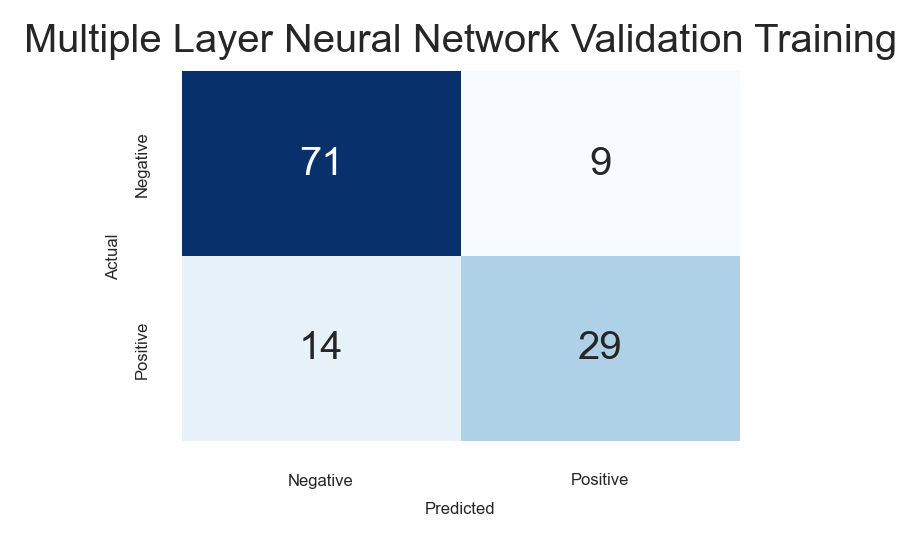

In [42]:
y_pred_best_model_multi_nn_train = best_model_multi_nn_2.predict(X_train_validation)

acc_multi_nn_train = accuracy_score(y_train_validation, y_pred_best_model_multi_nn_train)
balanced_accuracy_multi_nn_train = balanced_accuracy_score(y_train_validation, y_pred_best_model_multi_nn_train)
recall_multi_nn_train = recall_score(y_train_validation, y_pred_best_model_multi_nn_train, pos_label=1)
precision_multi_nn_train = precision_score(y_train_validation, y_pred_best_model_multi_nn_train, pos_label=1)
auc_multi_nn_train = roc_auc_score(pd.get_dummies(y_train_validation, drop_first=True), pd.get_dummies(y_pred_best_model_multi_nn_train, drop_first=True))
f1_multi_nn_train = f1_score(y_train_validation, y_pred_best_model_multi_nn_train, pos_label=1)
# fbeta_0_1 = fbeta_score(y_train_validation, y_pred_base_multi_nn, beta=0.1, pos_label=1)
# fbeta_10 = fbeta_score(y_train_validation, y_pred_base_multi_nn, beta=10, pos_label=1)
conf_matrix_multi_nn_base_train = confusion_matrix(y_train_validation, y_pred_best_model_multi_nn_train)

print(f'Accuracy Multi Layer Validation Train: {acc_multi_nn_train}')
print('Balanced Accuracy Multi Layer Validation Train', balanced_accuracy_multi_nn_train * 100)
print('Recall Multi Layer Validation Train', recall_multi_nn_train)
print('Precision Multi Layer Validation Train', precision_multi_nn_train)
print('AUC Multi Layer Validation Train', auc_multi_nn_train)
print('F1 Score Multi Layer Validation Train', f1_multi_nn_train)
# print('F-beta (0.1)', fbeta_0_1_multi_nn_base_train)
# print('F-beta (10)', fbeta_10_multi_nn_base_train)

# Plotting the confusion matrix
plt.figure(figsize=(3, 2))
sns.heatmap(conf_matrix_multi_nn_base_train, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])

for text in ax.texts:
    text.set_size(5)
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
plt.xlabel('Predicted', fontsize=5)
plt.ylabel('Actual', fontsize=5)
plt.title('Multiple Layer Neural Network Validation Training')
plt.show()

# Evaluate Multi Layer Model using Test Set

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Multi Layer Model using Test Set

Accuracy Multi Layer Test: 0.7207792207792207
Balanced Accuracy Multi Layer Test 0.6955555555555556
Recall Multi Layer Test 0.6111111111111112
Precision Multi Layer Test 0.6
AUC Multi Layer Test 0.6955555555555556
F1 Score Multi Layer Test 0.6055045871559633


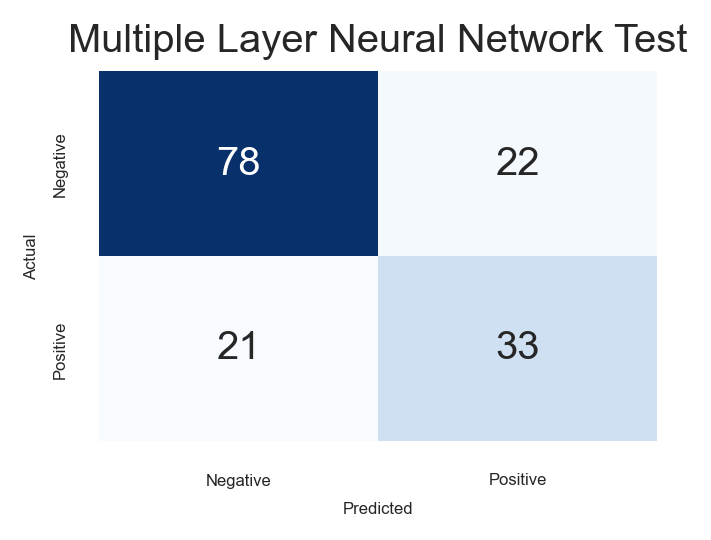

In [62]:
y_pred_best_model_multi_nn_test = best_model_multi_nn_2.predict(X_test)

acc_multi_nn_test = accuracy_score(y_test, y_pred_best_model_multi_nn_test)
balanced_accuracy_multi_nn_test = balanced_accuracy_score(y_test, y_pred_best_model_multi_nn_test)
recall_multi_nn_test = recall_score(y_test, y_pred_best_model_multi_nn_test, pos_label=1)
precision_multi_nn_test = precision_score(y_test, y_pred_best_model_multi_nn_test, pos_label=1)
auc_multi_nn_test = roc_auc_score(pd.get_dummies(y_test, drop_first=True), pd.get_dummies(y_pred_best_model_multi_nn_test, drop_first=True))
f1_multi_nn_test = f1_score(y_test, y_pred_best_model_multi_nn_test, pos_label=1)
# fbeta_0_1 = fbeta_score(y_train_validation, y_pred_base_multi_nn, beta=0.1, pos_label=1)
# fbeta_10 = fbeta_score(y_train_validation, y_pred_base_multi_nn, beta=10, pos_label=1)
conf_matrix_multi_nn_base_test = confusion_matrix(y_test, y_pred_best_model_multi_nn_test)

print("Multi Layer Model using Test Set")
print("")
print(f'Accuracy Multi Layer Test: {acc_multi_nn_test}')
print('Balanced Accuracy Multi Layer Test', balanced_accuracy_multi_nn_test)
print('Recall Multi Layer Test', recall_multi_nn_test)
print('Precision Multi Layer Test', precision_multi_nn_test)
print('AUC Multi Layer Test', auc_multi_nn_test)
print('F1 Score Multi Layer Test', f1_multi_nn_test)


# Plotting the confusion matrix
plt.figure(figsize=(3, 2))
sns.heatmap(conf_matrix_multi_nn_base_test, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])

for text in ax.texts:
    text.set_size(5)
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
plt.xlabel('Predicted', fontsize=5)
plt.ylabel('Actual', fontsize=5)
plt.title('Multiple Layer Neural Network Test')
plt.show()

# Create SVM Model

# Baseline SVM Model

Accuracy 0.7804878048780488
Balanced Accuracy 0.7882267441860464
Recall 0.813953488372093
Precision 0.6481481481481481
AUC 0.7882267441860465
F1 Score 0.7216494845360825
Confusion Matrix:


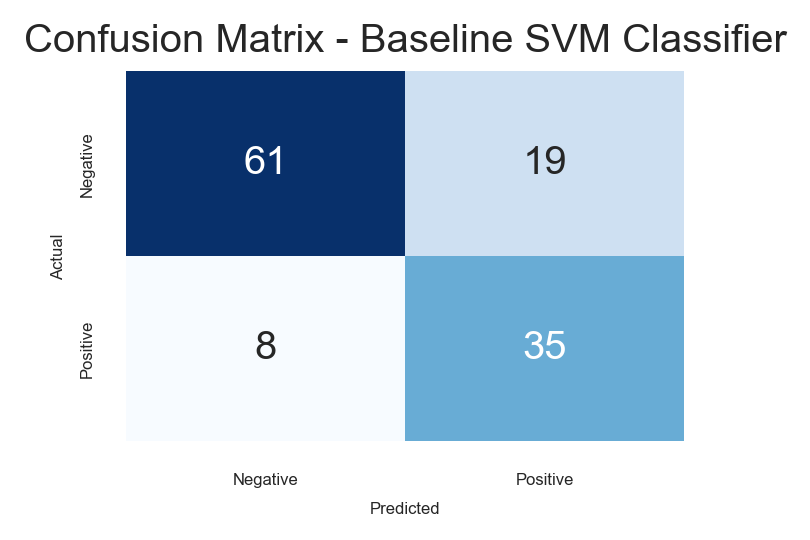

In [47]:
# SVM CLASSIFIER 

# Create pipeline
SVMModel = Pipeline(steps=[
    # ('imputation', SimpleImputer(missing_values=np.nan, strategy='median')),
    # ('scaling', StandardScaler()),
    ('svm_classifier', SVC(random_state=42, class_weight = 'balanced'))
])


SVMModel.fit(X_train_fit, y_train_fit)
y_pred_svm_baseline = SVMModel.predict(X_train_validation)

# Measure SVM classifier performance on scaled data
accuracy_svm = accuracy_score(y_train_validation, y_pred_svm_baseline)
balanced_accuracy_svm = balanced_accuracy_score(y_train_validation, y_pred_svm_baseline)
recall_svm = recall_score(y_train_validation, y_pred_svm_baseline, pos_label=1)
precision_svm = precision_score(y_train_validation, y_pred_svm_baseline, pos_label=1)
auc_svm = roc_auc_score(pd.get_dummies(y_train_validation, drop_first=True), pd.get_dummies(y_pred_svm_baseline, drop_first=True))
f1_svm = f1_score(y_train_validation, y_pred_svm_baseline, pos_label=1)
conf_matrix_svm = confusion_matrix(y_train_validation, y_pred_svm_baseline)

print('Accuracy', accuracy_svm)
print('Balanced Accuracy', balanced_accuracy_svm)
print('Recall', recall_svm)
print('Precision', precision_svm)
print('AUC', auc_svm)
print('F1 Score', f1_svm)

      
print("Confusion Matrix:")


# Plotting the confusion matrix
plt.figure(figsize=(3, 2))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])

for text in ax.texts:
    text.set_size(5)
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
plt.xlabel('Predicted', fontsize=5)
plt.ylabel('Actual', fontsize=5)
plt.title('Confusion Matrix - Baseline SVM Classifier')
plt.show()

# SVM HyperParameter Tuning

In [48]:
if __name__ == "__main__":
    multiprocessing.set_start_method('fork', force=True)
    
    # Define the parameter grid
    svm_param_grid = {
        'svm_classifier__C': [0.1, 0.5, 1, 5, 10, 100],
        'svm_classifier__kernel': ['rbf','sigmoid'],
        'svm_classifier__gamma': [0.0001, 0.01, 0.1, 1, 10, 'scale', 'auto'],
        'svm_classifier__degree': [1, 2, 3],
        'svm_classifier__class_weight':['balanced']
    }
    
    # Set up GridSearchCV
    svm_grid_search= GridSearchCV(SVMModel, svm_param_grid, cv=3, scoring='f1', n_jobs=-1, verbose = 3)
    
    # Fit GridSearchCV to the training data
    svm_grid_search.fit(X_train_fit, y_train_fit)
    best_params_svm = svm_grid_search.best_params_
    best_svm_clf = svm_grid_search.best_estimator_

    # Print the best parameters
    print("Best parameters found: ", best_params_svm)


Fitting 3 folds for each of 252 candidates, totalling 756 fits
Best parameters found:  {'svm_classifier__C': 0.5, 'svm_classifier__class_weight': 'balanced', 'svm_classifier__degree': 1, 'svm_classifier__gamma': 'scale', 'svm_classifier__kernel': 'rbf'}


In [49]:
# Get the best parameters and best estimator
best_params_svm = svm_grid_search.best_params_
best_svm_clf = svm_grid_search.best_estimator_

# Print the best parameters
print("Best parameters found: ", best_params_svm)

Best parameters found:  {'svm_classifier__C': 0.5, 'svm_classifier__class_weight': 'balanced', 'svm_classifier__degree': 1, 'svm_classifier__gamma': 'scale', 'svm_classifier__kernel': 'rbf'}


# Evaluate the optimized SVM model on the Train data

Accuracy 0.7723577235772358
Balanced Accuracy 0.7819767441860466
Recall 0.813953488372093
Precision 0.6363636363636364
AUC 0.7819767441860466
F1 Score 0.7142857142857143
Confusion Matrix:


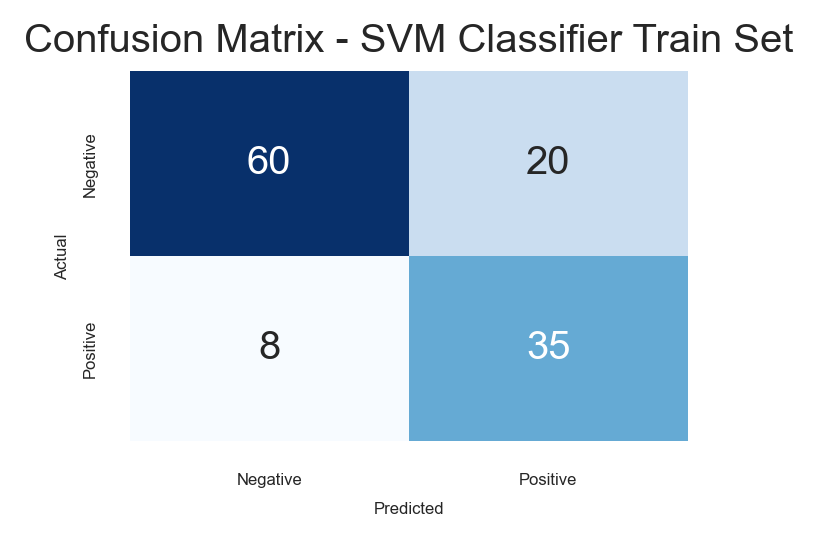

In [50]:
# Evaluate the optimized model on the test data
y_pred_best_svm_train = best_svm_clf.predict(X_train_validation)

# Measure performance using the optimized SVM classifier
accuracy_best_svm_train = accuracy_score(y_train_validation, y_pred_best_svm_train)
balanced_accuracy_best_svm_train = balanced_accuracy_score(y_train_validation, y_pred_best_svm_train)
recall_best_svm_train = recall_score(y_train_validation, y_pred_best_svm_train, pos_label=1)
precision_best_svm_train = precision_score(y_train_validation, y_pred_best_svm_train, pos_label=1)
auc_best_svm_train = roc_auc_score(pd.get_dummies(y_train_validation, drop_first=True), pd.get_dummies(y_pred_best_svm_train, drop_first=True))
f1_best_svm_train = f1_score(y_train_validation, y_pred_best_svm_train, pos_label=1)
# fbeta_0_1_best_svm = fbeta_score(y_train_validation, y_pred_best_svm, beta=0.1, pos_label=1)
# fbeta_10_best_svm = fbeta_score(y_train_validation, y_pred_best_svm, beta=10, pos_label=1)
conf_matrix_best_svm_train = confusion_matrix(y_train_validation, y_pred_best_svm_train)


print('Accuracy SVM Validation Train', accuracy_best_svm_train)
print('Balanced Accuracy SVM Validation Train', balanced_accuracy_best_svm_train)
print('Recall SVM Validation Train', recall_best_svm_train)
print('Precision SVM Validation Train', precision_best_svm_train)
print('AUC SVM Validation Train', auc_best_svm_train)
print('F1 Score SVM Validation Train', f1_best_svm_train)
      
print("Confusion Matrix:")

# Plotting the confusion matrix
plt.figure(figsize=(3, 2))
sns.heatmap(conf_matrix_best_svm_train, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])

for text in ax.texts:
    text.set_size(5)
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
plt.xlabel('Predicted', fontsize=5)
plt.ylabel('Actual', fontsize=5)
plt.title('Confusion Matrix - SVM Classifier Train Set')
plt.show()

# Evaluate the optimized SVM model on the Test data

Accuracy 0.7467532467532467
Balanced Accuracy 0.7538888888888888
Recall 0.7777777777777778
Precision 0.6086956521739131
AUC 0.7538888888888888
F1 Score 0.6829268292682927
Confusion Matrix:


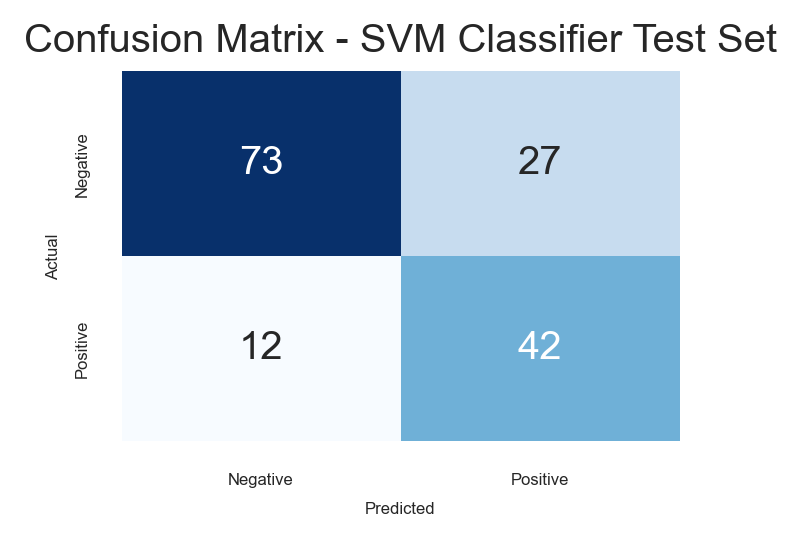

In [51]:
# Evaluate the optimized model on the test data
y_pred_best_svm_test = best_svm_clf.predict(X_test)

# Measure performance using the optimized SVM classifier
accuracy_best_svm_test = accuracy_score(y_test, y_pred_best_svm_test)
balanced_accuracy_best_svm_test = balanced_accuracy_score(y_test, y_pred_best_svm_test)
recall_best_svm_test = recall_score(y_test, y_pred_best_svm_test, pos_label=1)
precision_best_svm_test = precision_score(y_test, y_pred_best_svm_test, pos_label=1)
auc_best_svm_test = roc_auc_score(pd.get_dummies(y_test, drop_first=True), pd.get_dummies(y_pred_best_svm_test, drop_first=True))
f1_best_svm_test = f1_score(y_test, y_pred_best_svm_test, pos_label=1)
# fbeta_0_1_best_svm = fbeta_score(y_train_validation, y_pred_best_svm, beta=0.1, pos_label=1)
# fbeta_10_best_svm = fbeta_score(y_train_validation, y_pred_best_svm, beta=10, pos_label=1)
conf_matrix_best_svm_test = confusion_matrix(y_test, y_pred_best_svm_test)


print('Accuracy SVM Test', accuracy_best_svm_test)
print('Balanced Accuracy SVM Test', balanced_accuracy_best_svm_test)
print('Recall SVM Test', recall_best_svm_test)
print('Precision SVM Test', precision_best_svm_test)
print('AUC SVM Test', auc_best_svm_test)
print('F1 Score SVM Test', f1_best_svm_test)
      
print("Confusion Matrix:")

# Plotting the confusion matrix
plt.figure(figsize=(3, 2))
sns.heatmap(conf_matrix_best_svm_test, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])

for text in ax.texts:
    text.set_size(5)
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
plt.xlabel('Predicted', fontsize=5)
plt.ylabel('Actual', fontsize=5)
plt.title('Confusion Matrix - SVM Classifier Test Set')
plt.show()

# Summary

In [53]:
print("")
print('Accuracy Perceptron Test', acc_best_model_single_nn_test)
print('Balanced Accuracy Perceptron Test', balanced_accuracy_best_model_single_nn_test)
print('Recall Perceptron Test', recall_best_model_single_nn_test)
print('Precision Perceptron Test', precision_best_model_single_nn_test)
print('AUC Perceptron Test', auc_best_model_single_nn_test)
print('F1 Score Perceptron Test', f1_best_model_single_nn_test)
print("")

print("")
print(f'Accuracy Multi Layer Test: {acc_multi_nn_test}')
print('Balanced Accuracy Multi Layer Test', balanced_accuracy_multi_nn_test)
print('Recall Multi Layer Test', recall_multi_nn_test)
print('Precision Multi Layer Test', precision_multi_nn_test)
print('AUC Multi Layer Test', auc_multi_nn_test)
print('F1 Score Multi Layer Test', f1_multi_nn_test)
print("")

print("")
print('Accuracy SVM Test', accuracy_best_svm_test)
print('Balanced Accuracy SVM Test', balanced_accuracy_best_svm_test)
print('Recall SVM Test', recall_best_svm_test)
print('Precision SVM Test', precision_best_svm_test)
print('AUC SVM Test', auc_best_svm_test)
print('F1 Score SVM Test', f1_best_svm_test)


Accuracy Perceptron Test 0.7142857142857143
Balanced Accuracy Perceptron Test 0.6692592592592592
Recall Perceptron Test 0.5185185185185185
Precision Perceptron Test 0.6086956521739131
AUC Perceptron Test 0.6692592592592593
F1 Score Perceptron Test 0.56


Accuracy Multi Layer Test: 0.7207792207792207
Balanced Accuracy Multi Layer Test 0.6955555555555556
Recall Multi Layer Test 0.6111111111111112
Precision Multi Layer Test 0.6
AUC Multi Layer Test 0.6955555555555556
F1 Score Multi Layer Test 0.6055045871559633


Accuracy SVM Test 0.7467532467532467
Balanced Accuracy SVM Test 0.7538888888888888
Recall SVM Test 0.7777777777777778
Precision SVM Test 0.6086956521739131
AUC SVM Test 0.7538888888888888
F1 Score SVM Test 0.6829268292682927


In [54]:
print('Accuracy Perceptron Validation Train', acc_best_model_single_nn_train)
print('Balanced Accuracy Perceptron Validation Train', balanced_accuracy_best_model_single_nn_train)
print('Recall Perceptron Validation Train', recall_best_model_single_nn_train)
print('Precision Perceptron Validation Train', precision_best_model_single_nn_train)
print('AUC Perceptron Validation Train', auc_best_model_single_nn_train)
print('F1 Score Perceptron Validation Train', f1_best_model_single_nn_train)
print("")
print(f'Accuracy Multi Layer Validation Train: {acc_multi_nn_train}')
print('Balanced Accuracy Multi Layer Validation Train', balanced_accuracy_multi_nn_train * 100)
print('Recall Multi Layer Validation Train', recall_multi_nn_train)
print('Precision Multi Layer Validation Train', precision_multi_nn_train)
print('AUC Multi Layer Validation Train', auc_multi_nn_train)
print('F1 Score Multi Layer Validation Train', f1_multi_nn_train)
print("")
print('Accuracy SVM Validation Train', accuracy_best_svm_train)
print('Balanced Accuracy SVM Validation Train', balanced_accuracy_best_svm_train)
print('Recall SVM Validation Train', recall_best_svm_train)
print('Precision SVM Validation Train', precision_best_svm_train)
print('AUC SVM Validation Train', auc_best_svm_train)
print('F1 Score SVM Validation Train', f1_best_svm_train)

Accuracy Perceptron Validation Train 0.8130081300813008
Balanced Accuracy Perceptron Validation Train 0.7755813953488373
Recall Perceptron Validation Train 0.6511627906976745
Precision Perceptron Validation Train 0.7777777777777778
AUC Perceptron Validation Train 0.7755813953488373
F1 Score Perceptron Validation Train 0.7088607594936709

Accuracy Multi Layer Validation Train: 0.8130081300813008
Balanced Accuracy Multi Layer Validation Train 78.09593023255815
Recall Multi Layer Validation Train 0.6744186046511628
Precision Multi Layer Validation Train 0.7631578947368421
AUC Multi Layer Validation Train 0.7809593023255812
F1 Score Multi Layer Validation Train 0.7160493827160493

Accuracy SVM Validation Train 0.7723577235772358
Balanced Accuracy SVM Validation Train 0.7819767441860466
Recall SVM Validation Train 0.813953488372093
Precision SVM Validation Train 0.6363636363636364
AUC SVM Validation Train 0.7819767441860466
F1 Score SVM Validation Train 0.7142857142857143


In [61]:
import pandas as pd

# Assuming these variables are already defined somewhere in the script
data = {
    "Metrics": ["Accuracy", "Balanced Accuracy", "Recall", "Precision", "AUC", "F1 Score"],
    "Perceptron Test": [
        acc_best_model_single_nn_test, 
        balanced_accuracy_best_model_single_nn_test, 
        recall_best_model_single_nn_test, 
        precision_best_model_single_nn_test, 
        auc_best_model_single_nn_test, 
        f1_best_model_single_nn_test
    ],
    "Perceptron Validation": [
        acc_best_model_single_nn_train, 
        balanced_accuracy_best_model_single_nn_train, 
        recall_best_model_single_nn_train, 
        precision_best_model_single_nn_train, 
        auc_best_model_single_nn_train, 
        f1_best_model_single_nn_train
    ],
    "Multi Layer Test": [
        acc_multi_nn_test, 
        balanced_accuracy_multi_nn_test, 
        recall_multi_nn_test, 
        precision_multi_nn_test, 
        auc_multi_nn_test, 
        f1_multi_nn_test
    ],
    "Multi Layer Validation": [
        acc_multi_nn_train, 
        balanced_accuracy_multi_nn_train, 
        recall_multi_nn_train, 
        precision_multi_nn_train, 
        auc_multi_nn_train, 
        f1_multi_nn_train
    ],
    "SVM Test": [
        accuracy_best_svm_test, 
        balanced_accuracy_best_svm_test, 
        recall_best_svm_test, 
        precision_best_svm_test, 
        auc_best_svm_test, 
        f1_best_svm_test
    ],
    "SVM Validation": [
        accuracy_best_svm_train, 
        balanced_accuracy_best_svm_train, 
        recall_best_svm_train, 
        precision_best_svm_train, 
        auc_best_svm_train, 
        f1_best_svm_train
    ]
}

df_final_evaluation = pd.DataFrame(data)
df_final_evaluation

,Metrics,Perceptron Test,Perceptron Validation,Multi Layer Test,Multi Layer Validation,SVM Test,SVM Validation
0,Accuracy,0.71,0.81,0.72,0.81,0.75,0.77
1,Balanced Accuracy,0.67,0.78,0.70,0.78,0.75,0.78
2,Recall,0.52,0.65,0.61,0.67,0.78,0.81
3,Precision,0.61,0.78,0.60,0.76,0.61,0.64
4,AUC,0.67,0.78,0.70,0.78,0.75,0.78
5,F1 Score,0.56,0.71,0.61,0.72,0.68,0.71
